<h1> <center>Classificação de Críticas de Cerveja <br> (Modelo Bag of Words) </h1>
<h2><center>Aprendizagem Automática</h2>
<h3><center>Instituto Superior de Engenharia <br>2023/2024</h3>
<center><img src='https://www.isel.pt/sites/default/files/SCI/Identidade/logo_ISEL_simplificado_cor.png' width=500>
<h3><center> Docente: <br>
Gonçalo Marques
</h3>
<h3> <center> Alunos: <br>
Henrique Matos nº 48608 <br>
Guilherme Prazeres nº 49777
</h3>

<h4><center>Data de entrega: 21/01/2024<br>

<hr>

# <center> Índice

1. [Introdução](#introducao)
2. [Dados](#dados)
3. [Objetivos](#objetivos)
    1. [Aprendizagem Supervisionada vs Não Supervisionada](#superv)
4. [Desenvolvimento](#3-desenvolvimento)
    1. [Vocabulário](#vocab)
        1. [Construção do Melhor Vocabulário](#constr)
    2. [Tf-Idf](#tfidf)
    3. [Stemming](#stem)
    4. [Classificação Binária](#bin)
        1. [Procura dos Melhores Valores para Construção do Vocabulário](#procmelh)
        2. [Regressão Logística](#reglogbin)
        3. [KNN](#knnbin)
        4. [SVM](#svmbin)
    5. [Classificação Multiclasse](#mult)
        1. [Regressão Logística](#reglogmult)
        2. [KNN](#knnmult)
    6. [Classificadores Adicionais](#adic)
        1. [PCA](#pca)
            1. [Aplicação do PCA para caso binário](#pcabin)
            2. [Aplicação do PCA para caso multiclasse](#pcamult)
        2. [K-Means](#kmeans)
5. [Conclusões](#conc)
6. [Bibliografia](#bibliografia)


<hr>

# <center> Introdução <a name="introducao"></a>

No âmbito da unidade curricular de Aprendizagem Automática, foi proposto o desenvolvimento de um projeto cuja finalidade seria a classificaçáo de críticas relativas a várias cervejas, com base em diversas categorias de classificação, nomeadamente cheiro, sabor, textura, aparência, estilo e uma classificação geral (de 0 a 10).

O documento desenvolvido apresenta os vários passos à classificação final das críticas, nomeadamente o pré-processamento, estudo de otimização dos classificadores em uso e os seus respetivos testes e, por fim, a classificação das críticas em estudo e observações de resultados.

A construção do vocabulário ótimo e, posterior classificação, apresenta-se apoiada sob os conceitos de aprendizagens supervisionada vs não supervisionada, já que, tal como será abordado no documento, ambas complementam-se, tendo em conta que os métodos não supervisionados podem ser benéficos para a classificação através dos métodos supervisionados, nomeadamente na limpeza e otimização do vocabulário em questão.

Assim, o documento apresenta-se estruturado da seguinte forma:
1. Dados utilizados e as suas noções
2. Conceitos de métodos supervisionados e não supervisionados
3. Construção do vocabulário e a importância da vetorização de documentos
4. Classificação binária e multiclasse
5. Aplicação de métodos não supervisionados, adicionais, e a sua otimização ao supervisionado
6. Conclusões

<hr>

# <center> 1. Dados <a name="dados"></a>

### Bibliotecas a serem utilizadas ao longo do projeto

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
import pickle
import re
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import SnowballStemmer

### Ficheiros de dados relativos às críticas das cervejas

As críticas de cerveja, a serem classificadas ao longo deste projeto, dividem-se em duas categorias:
- Lista de críticas para treino dos classificadores
    - Composta por 75 000 críticas
- Lista de críticas para teste aos classificadores
    - Composta por 25 000 críticas

Demonstrado na célula abaixo, verifica-se cada crítica é composta pelo seu texto por extenso, ou seja, os dados a serem processados e transformados em vocabulário, e as suas classes relativamente às classificações das suas características:
- Name
- Style
- Who
- Feel
- Look
- Smell
- Taste
- Overall (pontuação global característica da cerveja)

In [2]:
# Dicionario
beerDic_test=pickle.load(open('rateBeer75Ktrain.p','rb'))
beerDic_train=pickle.load(open('rateBeer25Ktest.p','rb'))

print('Tipo dos dados apresentados:',type(beerDic_test))

dicKeys=list(beerDic_test.keys())
print('\nKeys:', dicKeys[:5])

print('\nClasse 0:', beerDic_test['000000'])

Tipo dos dados apresentados: <class 'dict'>

Keys: ['000000', '000001', '000002', '000003', '000004']

Classe 0: {'name': 'Anderson Valley Brother Davids Double', 'style': 'Abbey Dubbel', 'who': 'dmtroyer', 'feel': '3/5', 'look': '3/5', 'smell': '2/5', 'taste': '3/5', 'overall': '4/10', 'review': '22oz.  Pours dark brown with a red rim and off-white head.  Nose is mostly sweet malt with fairly noticeable alcohol depending on the temperature.  Flavor is sweet malt with raisin and banana yeast with some slight spice on the finish.  Very true to the style, but less than inspiring.'}


# <center> 2. Objetivos <a name="objetivos"></a>

Em termos globais, o que se pretende realizar será a determinação da qualidade de uma cerveja baseado no que foi escrito sobre a mesma. 

Neste contexto surgem duas tarefas de classificação a ser implementadas: Binária e Multi-Classe.

Para cada tarefa de classificação, será necessário determinar qual o melhor vocabulário a utilizar, tendo em conta a classificação a ser efetuada (e, nomeadamente, os classificadores a serem utilizados). É importante ter em conta que o vocabulário terá de ter uma boa dimensão, sendo este rico o suficiente mas não extenso ao ponto de tornar a classificação demasiado exaustiva.


<hr>

## `Conceito` - Aprendizagem Supervisionada vs Não Supervisionada <a name="superv"></a>

No que toca aos algoritmos aplicados ao modelo Bag of Words, existem dois tipos de métodos de aprendizagem: <b>supervisionada</b> e <b>não supervisionada</b>, distinguindo-se pela consideração das classes pertencentes aos dados (documentos).

<b>Não Supervisionada</b>
- Este método de aprendizagem não tem em consideração as classes dos dados a classificar. Por norma, classificam os dados através de uma contagem da frequência de aparição das palavras nos documentos, sendo que no modelo BoW é comum gerar uma matriz esparsa, no final das operaçóes, devendo-se ao facto de nem todos os documentos apresentarem todas as palavras que constituem o texto na sua totalidade
- O método não supervisionado realiza a contagem das palavras, ordenando, ou não, com base na sua frequência 

Métodos de aprendizagem não supervisionada utilizados neste projeto:
- `TfIdfVectorizer()` para construção do vocabulário, criando os vetores de frequência do mesmo (matriz esparsa)
- `PCA()` que reduz os dados presentes nos vetores da matriz esparsa aos seus componentes principais, ou seja, reduz os vetores sem perderem o seu significado
- `Clustering` (usado o K-Means), agrupando as palavras com significados semelhantes em várias nuvens de dados, não tendo em atenção a classe a que pertencem


<b>Supervisionada</b>
- Distinguindo-se do anterior, este método de aprendizagem efetua o peso dos documentos com base na classe a que pertencem. Cada palavra pode pertencer a várias classes, sendo que cabe aos classificadores, deste tipo, determinar a classe a que pertencem corretamente
- Os métodos supervisionados são usados para dois tipos de classificações: binária e multiclasse. A classificação binária apresenta menor taxa de erro, normalmente, já que é suposto atribuir as palavras apenas a duas classes, sendo que na multiclasse o mesmo não acontece, podendo uma palavra pertencente a uma classificação muito boa aparecer nas classificações intermédias ou, até mesmo, nas classificações más.

Métodos de aprendizagem supervisionada utilizados neste projeto:
- `Knn()`, classificando os dados com base nos k vizinhos mais próximos de si
- `SVM()`, definindo qual o hiper-plano com maior margem
- `LogisticRegression()`, verificando qual a relação entre dados e classes

<hr>

# <center>3. Desenvolvimento <a name="desenvolvimento"></a>

## Vocabulário <a name="vocab"></a>

De modo a usar as técnicas de aprendizagem automática (classificação, regressão, clustering) neste tipo de dados (<i>text-based</i>) será necessário representar cada documento por um vetor numérico.

A estrutura do texto é descartada bem como a ordem das palavras, ou seja, o algoritmo em si só verifica, individualmente, cada palavra dentro do texto, sendo que no modelo 'Bag of Words', a sequência não será relevante. Isto aplica-se principalmente ao facto de frases com as mesmas palavras poderem ter significados opostos.

O resultado final da construção do vocabulário será uma matriz chamada '`documento-termo`', ou <i>`corpus`</i>, de formato:

<center>Formato = N * d

em que, 

N -> Número de exemplos fornecidos (dados em si)

d -> Dimensão dos dados (classes dos dados)

Assim sendo, o algoritmo de construção da matriz documento-termo seguirá os seguintes passos:

1. `Tokenization` - divide cada documento (texto) em palavras/tokens, seguindo um conjunto de regras (ex. separando as palavras nos textos através de caracteres de espaço ou pontuação) definido pelo programador
2. `Construção do Vocabulário` - construir um vocabulário por todas ou por um sub-conjunto das palavras presentes no corpus
3. `Codificação` - com base no vocabulário construído no passo anterior:
    - Contar o número de vezes que cada palavra do vocabulário aparece em cada documento
    - Representar cada documento por um vetor de d dimensões, uma por cada palavra no vocabulário, com valores proporcionais ao número de ocorrências dessa palavra no documento
4. Construir a matriz documento-termo (td)

<b> Problemas que podem surgir na construção do vocabulário </b>:

 As dimensões dos dados podem ser bastante variadas já que existem onomatopeias, conjungações de verbos (ex. fazendo, fiz, fizeste) que acabam por ser inúteis ou redundantes, respetivamente, à classificação dos dados, posteriormente. Não prestando atenção a este problema, o número de palavras do documento acaba por ser demasiado grande.

`Solução:`

Filtrar as palavras que não serão relevantes ao vocabulário, seja através de expressões regulares ou, como será verificado ao longo deste documento, implementando hiper-parâmetros que façam a limpeza para a construção da matriz documento-termo.

### Construção do vocabulário <a name="constr"></a>

Para a leitura dos dados em questão ser facilitada, desenvolveram-se as seguintes funções de apoio, sendo modulares para que se possam testar vários parâmetros:

In [2]:
def load_reviews(pickle_file):
    """ O método carrega o ficheiro pickle com as reviews de cerveja """
    return pickle.load(open(pickle_file, 'rb'))

def create_list_reviews_rating(beer_reviews):
    """ @beer_reviews -> dicionário com as reviews de cerveja

        Retorna uma lista separada com as críticas por extenso do utilizador
        e outra lista com a classificação atribuída pelo mesmo
    """
    reviews = []
    classes = []
    for key, valor in beer_reviews.items():
        reviews.append(valor['review'])
        classes.append(valor['overall'])
    return reviews, classes


Assim, carregando as críticas:

In [3]:
rev_teste = load_reviews('rateBeer75Ktrain.p')
rev_treino = load_reviews('rateBeer25Ktest.p')

review_teste, class_teste = create_list_reviews_rating(rev_teste)
review_treino, class_treino = create_list_reviews_rating(rev_treino)

In [4]:
print('\nReview teste:', review_teste[:5])
print('\nClassificação teste:', class_teste[:5])

print('\nReview treino:', review_treino[:5])
print('\nClassificação treino:', class_treino[:5])



Review teste: ['22oz.  Pours dark brown with a red rim and off-white head.  Nose is mostly sweet malt with fairly noticeable alcohol depending on the temperature.  Flavor is sweet malt with raisin and banana yeast with some slight spice on the finish.  Very true to the style, but less than inspiring.', 'Compliments of a trade with goldtwins, thanks!\tPoured dark with very little head.  Coffee bean and chocolate dominate from the start, slight sweetness in the middle and finishes with a bit of bitterness from the coffee.  A nice hefty porter for the winter months.', 'Pours a dark brown with a 1/2 inch head.  Aroma is roasty with some coffee and chocolate, but smells very lager-ish.  Perhaps a little too much hop.  Flavor is roasty, but the hop adds too much to that.  Almost tastes slightly burnt.  Not much else going on in the flavor department.  Not a bad beer in the least, but not terribly far above average.', 'Bottle, 2004 Vintage.Pours a viscous cheddar yellow with an aroma of barn

Verificamos que o texto e as suas classes foram bem carregados.

É de notar que nesta fase inicial, sabendo que queremos construir um vocabulário, apenas será relevante trabalhar com os dados, logo, para efeitos demonstrativos, será usada a variável `review_teste`. A função auxiliar acima carrega apenas a classificação <i>overall</i> de propósito para que se possa verificar, numa fase inicial, a correspondência ao texto.

Verifica-se que o tamanho dos dados de teste é 75000.

In [5]:
print('Tamaho do documento de teste:', len(review_teste))

Tamaho do documento de teste: 75000


Para implementar o modelo 'Bag of Words', podemos usar a função `CountVectorizer`.

Esta função faz as contagens para cada texto, a quantidade de vezes que as palavras aparecem no mesmo (dividindo o <i>corpus</i> em tokens).
- Após treinar o algoritmo (com o `fit()`), ao usarmos o atributo `.vocabulary_` teremos o vocabulário pronto a ser usado.

In [6]:
## Criar um vectorizer
cv = CountVectorizer().fit(review_teste)
print('Número de palavras diferentes no vocabulário:', len(cv.vocabulary_))
print('Vocabulário não ordenado:', cv.vocabulary_)

Número de palavras diferentes no vocabulário: 58138
Vocabulário não ordenado: {'22oz': 1332, 'pours': 40646, 'dark': 15488, 'brown': 9694, 'with': 57128, 'red': 42852, 'rim': 44026, 'and': 4533, 'off': 37026, 'white': 56756, 'head': 25603, 'nose': 36422, 'is': 28607, 'mostly': 35039, 'sweet': 50685, 'malt': 32687, 'fairly': 20700, 'noticeable': 36499, 'alcohol': 3843, 'depending': 16243, 'on': 37318, 'the': 51875, 'temperature': 51585, 'flavor': 21697, 'raisin': 42215, 'banana': 6475, 'yeast': 57703, 'some': 47985, 'slight': 47302, 'spice': 48493, 'finish': 21392, 'very': 55392, 'true': 53469, 'to': 52557, 'style': 49820, 'but': 10201, 'less': 31116, 'than': 51822, 'inspiring': 28114, 'compliments': 13530, 'of': 37015, 'trade': 53001, 'goldtwins': 24154, 'thanks': 51833, 'poured': 40629, 'little': 31713, 'coffee': 13011, 'bean': 6941, 'chocolate': 12074, 'dominate': 17632, 'from': 22761, 'start': 49049, 'sweetness': 50725, 'in': 27569, 'middle': 34038, 'finishes': 21397, 'bit': 8020, '

In [7]:
## Teremos que ordenar o vocabulário
vocab =  cv.vocabulary_
vocab = {k : v for k, v in sorted(vocab.items(), key=lambda item: item[1])}
print('Vocabulário ordenado:', vocab)

Vocabulário ordenado: {'00': 0, '000': 1, '00000000000': 2, '00007738': 3, '0001': 4, '000th': 5, '001': 6, '0013': 7, '001880': 8, '0019': 9, '002': 10, '003': 11, '00802a1ba': 12, '00am': 13, '01': 14, '010308': 15, '010509': 16, '010607': 17, '010910': 18, '011': 19, '013': 20, '014': 21, '01501': 22, '01546': 23, '016': 24, '01633': 25, '017': 26, '019': 27, '01935': 28, '01996': 29, '01se11': 30, '02': 31, '020': 32, '020202': 33, '020310': 34, '02032010': 35, '02051': 36, '020606': 37, '020803': 38, '020907': 39, '021010': 40, '021107': 41, '021110': 42, '022310': 43, '0233': 44, '02482208': 45, '02feb07': 46, '02pouring': 47, '02s': 48, '03': 49, '030110': 50, '030208': 51, '030303': 52, '030407': 53, '030707': 54, '030905': 55, '030911': 56, '031108': 57, '032460': 58, '033': 59, '03a': 60, '04': 61, '040205': 62, '040311': 63, '040402': 64, '040404': 65, '040607': 66, '040611': 67, '040808': 68, '0489': 69, '04feb08': 70, '04holy': 71, '04may10': 72, '04s': 73, '05': 74, '050'

Bastam estes testes para verificar que o algoritmo criado organiza o vocabulário, mas não estará normalizado. Ora, a normalização é importante nos algoritmos de aprendizagem automática para simplificar as classificações, já que vetores com normas diferentes acaba por implicar que o <b>vetor com maior norma terá maior peso</b>.

### Term Frequency - Inverse Document Frequency <a name="tfidf"></a>
#### (Método Tf-Idf)

O Tf-Idf, sendo um método de aprendizagem não-supervisionada, representa, de outra forma, a matriz de contagens documento-termo, dando mais relevância a termos mais informativos, sem fazer caso das classes a que os dados pertencem.
- Dá maior peso a termos que aparecem frequentemente num dado documento
- Se uma palavra aparece em poucos documentos, mas muitas vezes nestes poucos documentos, então esta palavra descreve bem o conteúdo do documento; O contrário já desvaloriza a palavra

A utilização solitária de 'Term Frequency' não consegue identificar que uma crítica seja positiva ou negativa, já que documentos compridos terão uma frequência de termos maior.
- Assim, poder-se-ia utilizar o TfidfTransformer, colocando cada vetor na hiper-esfera (norma=1)

In [8]:
review_teste_red = review_teste[:10]
rev_cv = cv.transform(review_teste_red)
rev_tfidf = TfidfTransformer().fit_transform(rev_cv).toarray()

## Vefifica-se que ficou normalizada a norma
print('Verificação das normas:\n', np.sum(rev_tfidf**2, axis=1))

## Verificação da matriz esparsa
print('Snippet da Matriz Esparsa:\n', np.round(rev_tfidf, 2))

Verificação das normas:
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Snippet da Matriz Esparsa:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


<hr>

Para simplificar este processo, basta fazer-se uso da função `TfidfVectorizer()`, que é equivalente a fazer o `CountVectorizer + TfidfTransformer`:

In [10]:
def tfidf(df, token_pat, fit_data, transform_data):
    """ @docs -> lista somente com as reviews de cerveja por extenso
        @df -> frequência mínima de um termo para ser considerado
        @token_pat -> expressão regular para identificar um token com certo comprimento minimo
        @fit_data -> lista com as reviews de cerveja por extenso para o treino
        @transform_data -> lista com as reviews de cerveja por extenso para a transformação
    
        Retorna uma matriz com o tf-idf de cada documento, sendo que cada linha
        representa uma review e cada coluna representa um termo
    """
    vectorizer = TfidfVectorizer(min_df=df,token_pattern=token_pat).fit(fit_data)
    return vectorizer.get_feature_names_out(), vectorizer.transform(transform_data).toarray()

In [11]:
numero_tokens, rev_tfidf = tfidf(2, r'\b\w\w+\b', review_teste_red, review_teste_red)
print('Número de tokens:', len(numero_tokens))
print('Snippet da Matriz Esparsa:\n', np.round(rev_tfidf, 2))

Número de tokens: 97
Snippet da Matriz Esparsa:
 [[0.   0.17 0.   0.17 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.15 0.14 0.   0.   0.   0.   0.   0.   0.   0.   0.14 0.   0.
  0.12 0.   0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.1
  0.   0.   0.   0.22 0.   0.   0.   0.   0.19 0.   0.   0.3  0.   0.
  0.   0.   0.19 0.   0.   0.   0.   0.19 0.   0.   0.19 0.25 0.   0.
  0.   0.   0.   0.14 0.   0.19 0.   0.   0.14 0.   0.   0.3  0.   0.19
  0.19 0.   0.25 0.   0.   0.12 0.   0.1  0.   0.   0.17 0.37 0.  ]
 [0.   0.   0.   0.18 0.   0.   0.   0.   0.   0.21 0.   0.21 0.   0.
  0.   0.   0.   0.   0.   0.18 0.   0.   0.   0.36 0.   0.15 0.   0.
  0.   0.   0.   0.   0.15 0.32 0.   0.   0.   0.   0.   0.   0.   0.11
  0.   0.   0.13 0.   0.   0.   0.   0.   0.   0.   0.16 0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.16 0.   0.   0.22 0.   0.   0.   0.
  0.   0.21 0.18 0.   0.   0.21 0.   0.   0.   0.21 0.   0.   0.21 0.
  0.   0.   0.36 0.   0.   0.   0.   0

A limpeza do vocabulário com o `TfidfVectorizer()` definiu:
- Mínimo de repetição de palavra por documento: 2 (min_df)
- Mínimo de caracteres por palavra: 2 (token_pattern)

Irá ser repetido o teste para outros valores de min_df e para o mínimo de caracteres.

In [11]:
list_df = [2, 3, 4] # frequência mínima de um termo para ser considerado de 2, 3 e 4
list_token_pat = [r'\b\w\w+\b', r'\b\w\w\w+\b', r'\b\w\w\w\w+\b'] # 2, 3 e 4 caracteres
list_tokens = []
for df in list_df:
    for token_pat in list_token_pat:
        numero_tokens, rev_tfidf = tfidf(df, token_pat, review_teste_red, review_teste_red)
        list_tokens.append(numero_tokens)
        print('Número de tokens:', len(numero_tokens), 'com df =', df, 'e token_pat =', token_pat)

Número de tokens: 97 com df = 2 e token_pat = \b\w\w+\b
Número de tokens: 87 com df = 2 e token_pat = \b\w\w\w+\b
Número de tokens: 75 com df = 2 e token_pat = \b\w\w\w\w+\b
Número de tokens: 47 com df = 3 e token_pat = \b\w\w+\b
Número de tokens: 40 com df = 3 e token_pat = \b\w\w\w+\b
Número de tokens: 34 com df = 3 e token_pat = \b\w\w\w\w+\b
Número de tokens: 33 com df = 4 e token_pat = \b\w\w+\b
Número de tokens: 28 com df = 4 e token_pat = \b\w\w\w+\b
Número de tokens: 23 com df = 4 e token_pat = \b\w\w\w\w+\b


In [12]:
## Verificação dos tokens

print('Tokens com df = 2 e token_pat = 2 caracteres: \n', list_tokens[0], '\n')
print('Tokens com df = 2 e token_pat = 3 caracteres: \n', list_tokens[1], '\n')
print('Tokens com df = 2 e token_pat = 4 caracteres: \n', list_tokens[2], '\n')
print('Tokens com df = 3 e token_pat = 2 caracteres: \n', list_tokens[3], '\n')
print('Tokens com df = 3 e token_pat = 3 caracteres: \n', list_tokens[4], '\n')
print('Tokens com df = 3 e token_pat = 4 caracteres: \n', list_tokens[5], '\n')
print('Tokens com df = 4 e token_pat = 2 caracteres: \n', list_tokens[6], '\n')
print('Tokens com df = 4 e token_pat = 3 caracteres: \n', list_tokens[7], '\n')
print('Tokens com df = 4 e token_pat = 4 caracteres: \n', list_tokens[8])


Tokens com df = 2 e token_pat = 2 caracteres: 
 ['12' 'alcohol' 'amber' 'and' 'aroma' 'at' 'average' 'back' 'beer' 'bit'
 'bitter' 'bitterness' 'bodied' 'body' 'bottle' 'brown' 'but' 'caramel'
 'carbonation' 'chocolate' 'citrus' 'clean' 'clear' 'coffee' 'crisp'
 'dark' 'delicious' 'dry' 'finish' 'fizzy' 'flavor' 'foamy' 'for' 'from'
 'fruitiness' 'fruity' 'golden' 'good' 'grainy' 'great' 'have' 'head'
 'hop' 'hops' 'in' 'is' 'it' 'lacing' 'lager' 'left' 'less' 'light'
 'little' 'malt' 'malty' 'medium' 'moderate' 'more' 'mostly' 'mouthfeel'
 'much' 'my' 'nice' 'nose' 'not' 'of' 'off' 'on' 'one' 'orange' 'oz'
 'porter' 'poured' 'pours' 'roasty' 'slight' 'slightly' 'small' 'some'
 'start' 'sticky' 'sweet' 'sweetness' 'temperature' 'than' 'that' 'the'
 'thin' 'this' 'to' 'tongue' 'very' 'via' 'was' 'white' 'with' 'your'] 

Tokens com df = 2 e token_pat = 3 caracteres: 
 ['alcohol' 'amber' 'and' 'aroma' 'average' 'back' 'beer' 'bit' 'bitter'
 'bitterness' 'bodied' 'body' 'bottle' 'brown' 'b

Verifica-se que um bom meio termo será o uso de:
- min_df = 3
- regex com 3 ou mais caracteres

Estes hiper-parâmetros definem uma boa busca no algoritmo já que reduz algumas <i>stop words</i> sem especificar que se quer ignorá-las (não seria útil já que em inglês algumas stop words são boas para classificação), contendo palavras suficientemente boas para classificação futura.

No entanto, verifica-se que o vocabulário ainda contém tokens desnecessários à classificação.

Pode ser feita a limpeza através de expressões regulares, de modo a reduzir o número de tokens presentes.

In [12]:
def clean_document(review_list, regex):
    """ @review_list -> lista somente com as reviews de cerveja por extenso
    
        Efetua a limpeza do documento, removendo tags html e caracteres especiais
        de modo a facilitar o processamento do texto e diminuindo o numero de tokens
        cujo processamento não é relevante para a classificação 
    """
    reviews = [doc.replace('<br />', ' ') for doc in review_list] # Remover caracteres html
    reviews = [re.sub(regex, ' ', doc) for doc in review_list] # Substituir tudo o que não for letras por espaço
    return reviews

In [13]:
regex = r'[^a-zA-Z\u00C0-\u00FF]+' # Remove acentos e caracteres especiais
review_teste_clean = clean_document(review_teste, regex)
print('Snippet limpa:\n', review_teste_clean[0])

Snippet limpa:
  oz Pours dark brown with a red rim and off white head Nose is mostly sweet malt with fairly noticeable alcohol depending on the temperature Flavor is sweet malt with raisin and banana yeast with some slight spice on the finish Very true to the style but less than inspiring 


Aplicando agora o TfIdf:

In [14]:
## Aplicar tfidf à crítica limpa
rev_clean_snippet = review_teste_clean[:200]
numero_tokens, rev_tfidf = tfidf(2, r'\b\w\w+\b', rev_clean_snippet, rev_clean_snippet)
print('Número de tokens:', len(numero_tokens), '\n')
print('Tokens: \n', numero_tokens[:100])

Número de tokens: 1006 

Tokens: 
 ['about' 'above' 'abundant' 'abv' 'accent' 'accents' 'acceptable' 'acidic'
 'acidity' 'active' 'actually' 'added' 'adds' 'adequate' 'affordable'
 'after' 'aftertaste' 'again' 'against' 'age' 'aged' 'aggressive' 'aging'
 'ago' 'air' 'alcohol' 'ale' 'ales' 'all' 'allagash' 'almost' 'along'
 'alpine' 'also' 'amazing' 'amber' 'american' 'among' 'amount' 'an' 'and'
 'anderson' 'anniversary' 'annual' 'another' 'any' 'anything' 'apparent'
 'appearance' 'apple' 'apples' 'apr' 'april' 'are' 'aroma' 'aromas'
 'aromatic' 'around' 'as' 'ashy' 'astringent' 'at' 'aug' 'average' 'away'
 'awesome' 'back' 'backbone' 'background' 'bad' 'balance' 'balanced'
 'baltic' 'banana' 'barleywine' 'barrel' 'base' 'bay' 'be' 'bean' 'beans'
 'beautiful' 'becomes' 'been' 'beer' 'beers' 'before' 'behind' 'beige'
 'being' 'belgian' 'believe' 'belly' 'besides' 'best' 'better' 'big'
 'bigger' 'biscuit' 'biscuits']


Apresenta números e palavras que de certo modo significam o mesmo ('acidic, acidity'; 'beer, beers'; etc).
- Estas palavras cujo radical é partilhado, acabam por ter significados redundantes na classificação. Assim, para se reduzir estes significados a uma só palavra, cujo valor único será importante na classificação, terá de se fazer mais uma limpeza, utilizando `Stemmers`

#### Stemming <a name="stem"></a>

É o processo de transformar uma palavra na sua raíz, o que permite mapear palavras semelhantes numa única palavra. Fazer Stemming remove a parte final das palavras (sufixo), deixando apenas o seu 'stem' (a raíz).

Abordar-se-à 3 tipos de Stemmers, de modo a descobrir o melhor:
- Porter Stemmer: faz o stem palavra a palavra
- Snowball Stemmer: é necessário definir o idioma com que vamos lidar
- Lancaster Stemmer: é o mais automático

É de notar que todo e qualquer stemming deverá ser feito <b>antes</b> de utilizar o TfIdf.

In [24]:
def stemmer(review_list, stemmer_type):
    """ @review_list -> lista somente com as reviews de cerveja por extenso
        @stemmer_type -> tipo de stemmer a ser utilizado,
                            1 - PorterStemmer,
                            2 - LancasterStemmer,
                            3 - SnowballStemmer (processado em inglês)
        
        Retorna uma lista com as reviews de cerveja por extenso após a aplicação
        do stemmer indicado no parâmetro stemmer_type, de modo a reduzir a redundância
        de palavras, reduzindo-as ao seu radical, facilitando a classificação 
    """
    docs = []
    if stemmer_type == 1:
        stemmer = PorterStemmer()
        docs = [' '.join([stemmer.stem(word) for word in doc.split(' ')]) for doc in review_list]
    elif stemmer_type == 2:
        stemmer = LancasterStemmer()
        docs = [' '.join([stemmer.stem(word) for word in doc.split(' ')]) for doc in review_list]
    elif stemmer_type == 3:
        stemmer = SnowballStemmer('english')
        docs = [' '.join([stemmer.stem(word) for word in doc.split(' ')]) for doc in review_list]
    return docs

In [16]:
## Snippet de reviews de teste
rev_teste_snippet = review_teste[:200]
rev_teste_clean = clean_document(rev_teste_snippet, regex)
stemmers = [1, 2, 3]
##  1 - PorterStemmer
##  2 - LancasterStemmer
##  3 - SnowballStemmer (processado em inglês)
list_stemmers = []
for stem in stemmers:
    list_stemmers.append(stemmer(rev_teste_clean, stem))

## Aplicar tfidf a cada stemmer da lista
for i, stem in enumerate(list_stemmers):
    numero_tokens, rev_tfidf = tfidf(2, r'\b\w\w+\b', stem, stem)
    print('Número de tokens:', len(numero_tokens))
    print('Tokens: \n', numero_tokens[:50], '\n', '-'*50)

Número de tokens: 941
Tokens: 
 ['about' 'abov' 'abund' 'abv' 'accent' 'accentu' 'accept' 'acid' 'activ'
 'actual' 'ad' 'add' 'addit' 'adequ' 'afford' 'after' 'aftertast' 'again'
 'against' 'age' 'aggress' 'ago' 'air' 'alcohol' 'ale' 'all' 'allagash'
 'allow' 'almost' 'along' 'alpin' 'also' 'amaz' 'amber' 'american' 'among'
 'amount' 'an' 'and' 'anderson' 'ani' 'anniversari' 'annual' 'anoth'
 'anyth' 'appar' 'appear' 'appl' 'apr' 'april'] 
 --------------------------------------------------
Número de tokens: 895
Tokens: 
 ['about' 'abov' 'abund' 'abv' 'acc' 'acceiv' 'accentu' 'acid' 'act' 'ad'
 'addit' 'adequ' 'afford' 'aft' 'aftertast' 'ag' 'again' 'against'
 'aggress' 'ago' 'air' 'al' 'alcohol' 'allagash' 'allow' 'almost' 'along'
 'alpin' 'also' 'am' 'amaz' 'amb' 'among' 'amount' 'an' 'and' 'anderson'
 'annivers' 'anoth' 'any' 'anyth' 'app' 'appear' 'appl' 'apr' 'april' 'ar'
 'arom' 'aroma' 'around'] 
 --------------------------------------------------
Número de tokens: 926
Tokens: 


`Observações`:
1. A limpeza com expressões regulares reduz o número de tokens irrelevantes à classificação por uma boa margem, mas não é suficiente
2. A aplicação do TfidfVectorizer ajuda na limpeza, contabilizando apenas as palavras com uma certa frequência e número de caracteres, mas não ignora redundâncias
3. O Stemmer finaliza a limpeza, tratando das redundâncias no vocabulário, reduzindo-as ao seu radical

`Conclusão ao Stemmer`:
- O melhor será o Snowball Stemmer já que não reduz tão agressivamente as palavras como o Lancaster Stemmer, mas reduz suficientemente mais que o Porter Stemmer, mantendo o vocabulário 'legível' o suficiente pelo algoritmo de classificação de modo a que se possa obter melhores resultados.

<hr>

#### Funções para verificação pós-classificação

In [40]:
def taxa_erro(classe_teste, y_pred):
    """ @classe_teste -> lista com a classificação de cada review
        @y_pred -> lista com a classificação prevista para cada review

        Retorna a taxa de erro para cada classe
    """
    return np.sum(classe_teste != y_pred)/len(classe_teste)*100

def print_confusion_matrix(y_true, y_pred):
    """ @y_true -> lista com a classificação binária de cada review
        @y_pred -> lista com a classificação binária prevista de cada review

        Imprime a matriz de confusão
    """
    return confusion_matrix(y_true, y_pred)

## Classificação Binária <a name="bin"></a>

<i>Nesta tarefa, pretende-se saber se o critico considera a cerveja muito boa ou muito má, baseado no que escreveu. Considere que uma cerveja e considerada muito boa quando obteve uma pontuação global (campo `overall`) de 9 ou mais valores. Considere ainda que
uma cerveja e considerada muito má quando obteve uma pontuacao global de 2 ou menos valores.</i>

Neste tipo de classificação apresentam-se as seguintes tarefas a realizar:
1. Separação das classes do vocabulário de modo a diferenciar as críticas muito boas (>=9) das muito más (<=2)
    - Para tal, serão criadas duas listas responsáveis pela gestão das críticas boas e más, ou seja:
        - Muito boas: de 9 para cima, inclusive, será transformado a 1 e o restante a 0
        - Muito más: de 2 para baixo, inclusive, será transformado a 1 e o restante a 0
2. Limpeza do vocabulário, aplicação de Stemmers e transformação na matriz termo-documento
3. Aplicação de classificadores

Para a classificação binária serão usados os classificadores:
- Regressão Logística
- KNN (K-Nearest Neighbors)
- SVM (Support Vector Machine)

Sabendo que se trata de uma classificação binária, as classes a serem usadas terão de ser transformadas em duas listas de classes com 0 e 1. Assim, desenvolveu-se o seguinte código:

In [7]:
def transform_rating_to_binary(classes):
    """ @classes -> lista com a classificação atribuída às cervejas

        Retorna uma lista com a classificação binária, sendo que 1 representa
        uma classificação muito positiva (>= 9) e 0 uma classificação 
        muito negativa (<= 2).
    """
    classe_bin_pos = []
    classe_bin_neg = []
    for i in range(len(classes)):
        if classes[i] == '9/10' or classes[i] == '10/10':
            classe_bin_pos.append(1)
        else:
            classe_bin_pos.append(0)

    for i in range(len(classes)):
        if classes[i] == '0/10' or classes[i]=='1/10' or classes[i] == '2/10':
            classe_bin_neg.append(1)
        else:
            classe_bin_neg.append(0)

    return np.asarray(classe_bin_pos), np.asarray(classe_bin_neg)

### Procura dos Melhores Valores para Construção do Vocabulário <a name="procmelh"></a>

Começa-se por inicializar o vocabulário e a sua limpeza:

In [9]:
rev_treino = load_reviews('../testFiles/rateBeer75Ktrain.p')
rev_teste = load_reviews('../testFiles/rateBeer25Ktest.p')

reviews_treino_full, classes_treino = create_list_reviews_rating(rev_treino)
reviews_teste_full, classes_teste = create_list_reviews_rating(rev_teste)

## Test train split para que se possa achar os melhores valores em testes
reviews_treino, reviews_teste, ytr, yts = train_test_split(reviews_treino_full, classes_treino, test_size=0.3, random_state=42)

ytr_bin_pos, ytr_bin_neg = transform_rating_to_binary(ytr)
yts_bin_pos, yts_bin_neg = transform_rating_to_binary(yts)

reviews_treino = clean_document(reviews_treino, r'[^a-zA-Z\u00C0-\u00FF]+')
reviews_teste = clean_document(reviews_teste, r'[^a-zA-Z\u00C0-\u00FF]+')

reviews_treino = stemmer(reviews_treino, 3)
reviews_teste = stemmer(reviews_teste, 3)

In [10]:
## Críticas completas, sem split(), para usar mais tarde

classe_tr_bin_pos, classe_tr_bin_neg = transform_rating_to_binary(classes_treino)
classe_ts_bin_pos, classe_ts_bin_neg = transform_rating_to_binary(classes_teste)

critica_treino = clean_document(reviews_treino_full, r'[^a-zA-Z\u00C0-\u00FF]+')
critica_teste = clean_document(reviews_teste_full, r'[^a-zA-Z\u00C0-\u00FF]+')

critica_treino = stemmer(critica_treino, 3)
critica_teste = stemmer(critica_teste, 3)

Irá ser procurado o melhor hiper-parâmetro para TfIdf

In [21]:
min_df_list =  [2, 3, 4]
token_pattern_list = [r'b\w\w\w\w+\b', r'\b\w\w\w+\b', r'\b\w\w+\b'] # com digitos e sem digitos

nr_features = 0
for df in min_df_list:
    print('------------------------------------------', '\n')
    for token_pat in token_pattern_list:
        print('Iteração no min_df atual: ', df)
        print('Iteração no token_pattern atual: ', token_pat)
        feature_names, Xtr = tfidf(df, token_pat, reviews_treino, reviews_treino)
        print('Número de features: ', len(feature_names))
        print('------------------') 

------------------------------------------ 

Iteração no min_df atual:  2
Iteração no token_pattern atual:  b\w\w\w\w+\b
Número de features:  1306
------------------
Iteração no min_df atual:  2
Iteração no token_pattern atual:  \b\w\w\w+\b
Número de features:  16856
------------------
Iteração no min_df atual:  2
Iteração no token_pattern atual:  \b\w\w+\b
Número de features:  17196
------------------
------------------------------------------ 

Iteração no min_df atual:  3
Iteração no token_pattern atual:  b\w\w\w\w+\b
Número de features:  963
------------------
Iteração no min_df atual:  3
Iteração no token_pattern atual:  \b\w\w\w+\b
Número de features:  12829
------------------
Iteração no min_df atual:  3
Iteração no token_pattern atual:  \b\w\w+\b
Número de features:  13123
------------------
------------------------------------------ 

Iteração no min_df atual:  4
Iteração no token_pattern atual:  b\w\w\w\w+\b
Número de features:  771
------------------
Iteração no min_df atual

Avaliando os resultados, conclui-se que um número mínimo de ocorrências de palavras e um número mínimo de caracteres que sejam benéficos será de:
- min_df = 3 -> três ocorrências 
- token_pattern = \b\w\w\w+\b -> três caracteres, pelo menos

Assim, o tfidf a ser usado será:

In [11]:
## Para as críticas com split()
token_treino_small, rev_tfidf_treino_small = tfidf(3, r'\b\w\w\w+\b', reviews_treino, reviews_treino)
token_teste_small, rev_tfidf_teste_small = tfidf(3, r'\b\w\w\w+\b', reviews_treino, reviews_teste)

In [12]:
## Para as críticas completas
tokens_treino, critica_tfidf_treino = tfidf(3, r'\b\w\w\w+\b', critica_treino, critica_treino)
tokens_teste, critica_tfidf_teste = tfidf(3, r'\b\w\w\w+\b', critica_treino, critica_teste)

### Regressão Logística <a name="reglogbin"></a>

A Regressão Logística é um método de aprendizagem supervisionada usado em tarefas de classificação binária, ou seja, especializa-se em determinar se um dado pertence, ou não, a uma certa classe.
- De um modo prático, analisa a relação existente entre as variáveis independentes (dados) e as variáveis dependentes (classes), sendo estas últimas <b>binárias</b>.

Para que se possa usar na classificação final, verificar-se-ão, com o conjunto de teste criado com uso da função `split()`, quais os melhores hiper-parâmetros.

Para tal, é importante ter em consideração:
- Irão ser verificados os melhores valores para a penalização e para C
    - C -> quanto maior o seu valor, maior peso terão os dados de treino, o que pode induzir o modelo em sobre-aprendizagem (<i>overfitting</i>)
    - Penalização -> dependendo de qual se escolha, o resultado varia
        - L1 (Lasso) é usado quando se pretende classificar um grande número de dados, metendo vários dos pesos a zero, eliminando as palavras menos discriminativas. Esta penalização reduz bastante o número das palavras
        - L2 (Ridge) representa a soma quadrada de cada peso do discriminante logístico, sendo que é usado quando queremos reduzir os coeficientes para um número perto de zero

Serão usadas as seguintes funções:

In [29]:
def find_best_values_log_regress(data, target):
    """ @data -> matriz com o tf-idf de cada documento
        @target -> lista com a classificação binária de cada review

        Retorna os melhores valores para o modelo de regressão linear
    """
    best_penalty_list = ['l1', 'l2']
    best_C_list = [0.001, 0.1, 1]
    best_score = 0
    for penalty in best_penalty_list:
        print('Iteração na penalização atual: ', penalty)
        for C in best_C_list:
            print('Iteração no C atual: ', C)
            model = LogisticRegression(penalty=penalty, max_iter=1000, C=C, tol=1e-3, solver='saga')
            model.fit(data, target)
            score = model.score(data, target)
            if score > best_score:
                best_penalty = penalty
                best_C = C
                best_score = score
    return best_penalty, best_C, best_score

def apply_best_log_regress(best_penalty, best_C):
    """ @data -> matriz com o tf-idf de cada documento
        @target -> lista com a classificação binária de cada review

        Retorna o modelo de regressão logística treinado com os melhores valores
        obtidos pela função de teste, find_best_values_lregress
    """
    model = LogisticRegression(penalty=best_penalty, max_iter=1000, C=best_C, tol=1e-3, solver='saga')
    return model

In [30]:
# Procurar os melhores valores para o modelo de regressão logistica
best_penalty, best_C, best_score = find_best_values_log_regress(rev_tfidf_treino_small, ytr_bin_pos)
print('Melhor penalização: ', best_penalty)
print('Melhor C: ', best_C)
print('Melhor score: ', best_score)

# Escrever num pickle file os melhores valores para o modelo de regressão logistica
pickle.dump(best_penalty, open('best_penalty_log_reg_bin.p', 'wb'))
pickle.dump(best_C, open('best_C_log_reg_bin.p', 'wb'))

Iteração na penalização atual:  l1
Iteração no C atual:  0.001
Iteração no C atual:  0.1
Iteração no C atual:  1
Iteração na penalização atual:  l2
Iteração no C atual:  0.001
Iteração no C atual:  0.1
Iteração no C atual:  1
Melhor penalização:  l2
Melhor C:  1
Melhor score:  0.9404761904761905


Encontrados os melhores valores do regressor logístico, classificar-se-ão as críticas positivas e negativas, tanto para conjunto de teste como de treino:

In [31]:
## Classificação das críticas positivas e negativas, dos conjuntos
##      de teste e treino completos

## Aplicar o modelo de regressão logistica aos dados de treino
# Dados positivos de treino
model_log_regress_pos = apply_best_log_regress(best_penalty, best_C)
model_log_regress_pos.fit(critica_tfidf_treino, classe_tr_bin_pos)
# Dados negativos de treino
model_log_regress_neg = apply_best_log_regress(best_penalty, best_C)
model_log_regress_neg.fit(critica_tfidf_treino, classe_tr_bin_neg)

# Prever os dados de teste
y_pred_pos = model_log_regress_pos.predict(critica_tfidf_teste)
y_pred_neg = model_log_regress_neg.predict(critica_tfidf_teste)

# Verificar as pontuações
score_train_pos = model_log_regress_pos.score(critica_tfidf_treino, classe_tr_bin_pos)
score_train_neg = model_log_regress_neg.score(critica_tfidf_treino, classe_tr_bin_neg)
score_test_pos = model_log_regress_pos.score(critica_tfidf_teste, classe_ts_bin_pos)
score_test_neg = model_log_regress_neg.score(critica_tfidf_teste, classe_ts_bin_neg)

print('Previsão de teste positivos: ', y_pred_pos)
print('Previsão de teste negativos: ', y_pred_neg)
print('Score treino positivo: ', score_train_pos)
print('Score treino negativo: ', score_train_neg)
print('Score teste positivo: ', score_test_pos)
print('Score teste negativo: ', score_test_neg)

Previsão de teste positivos:  [0 0 0 ... 0 0 0]
Previsão de teste negativos:  [0 0 0 ... 0 0 0]
Score treino positivo:  0.9401866666666666
Score treino negativo:  0.9636
Score teste positivo:  0.95592
Score teste negativo:  0.91692


Irá então ser verificado o equilíbrio do vocabulário, resultante da classificação:

Numero de dimensões resultantes para classificação:  15179
Palavras mais relevantes para classificação negativa:  ['off', 'note', 'medium', 'attract', 'though', 'least', 'would', 'someth', 'lager', 'amber', 'metal', 'weak', 'quit', 'apa', 'ester', 'malti', 'water', 'grain', 'herbal', 'prefer', 'rather', 'style', 'blankboy', 'enjoy', 'mayb', 'roast', 'usual', 'yeasti', 'miner', 'general', 'food', 'almond', 'lcbo', 'label', 'infect', 'plenti', 'bore', 'soda', 'collabor', 'crown', 'domin', 'transpar', 'khaki', 'golden', 'size', 'south', 'medicin', 'mode', 'lengthi', 'anyway', 'unbalanc', 'didnt', 'still', 'chalki', 'okay', 'stale', 'sharp', 'butterscotch', 'retent', 'faint', 'here', 'dissapoint', 'earlier', 'isnt', 'given', 'hogtownharri', 'addit', 'nutti', 'diacetyl', 'simpl', 'draft', 'expect', 'perhap', 'thinner', 'resini', 'overal', 'white', 'potenti', 'rocki', 'macadamia', 'rough', 'worst', 'zappa', 'surpris', 'buck', 'exil', 'tripel', 'milki', 'disappoint', 'bomber', 'bitter', 'dime

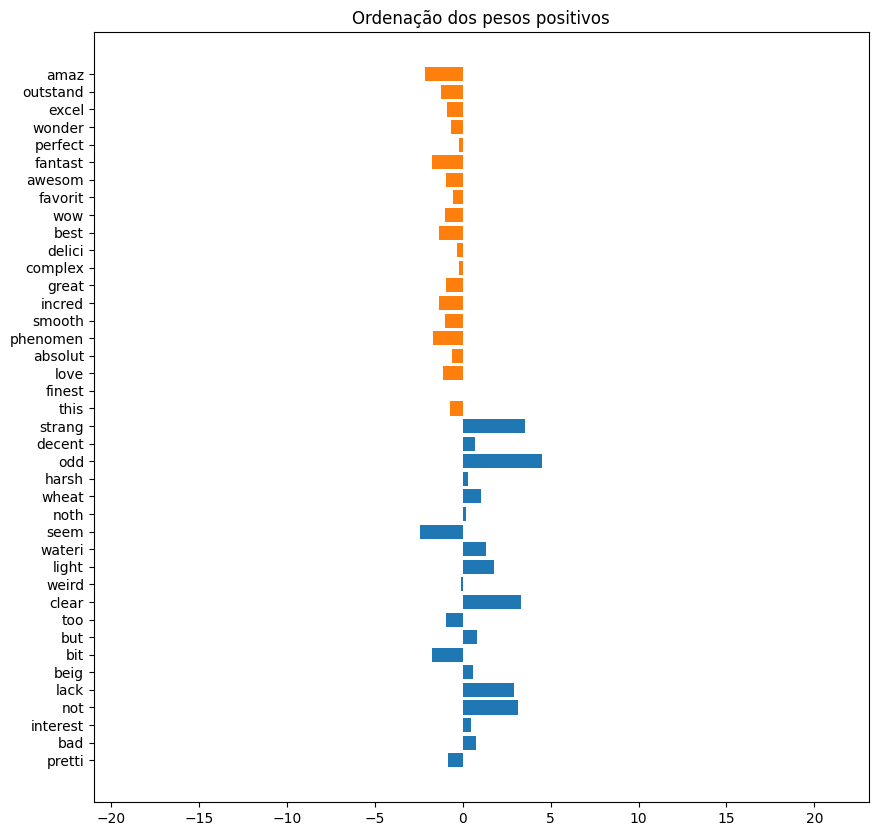

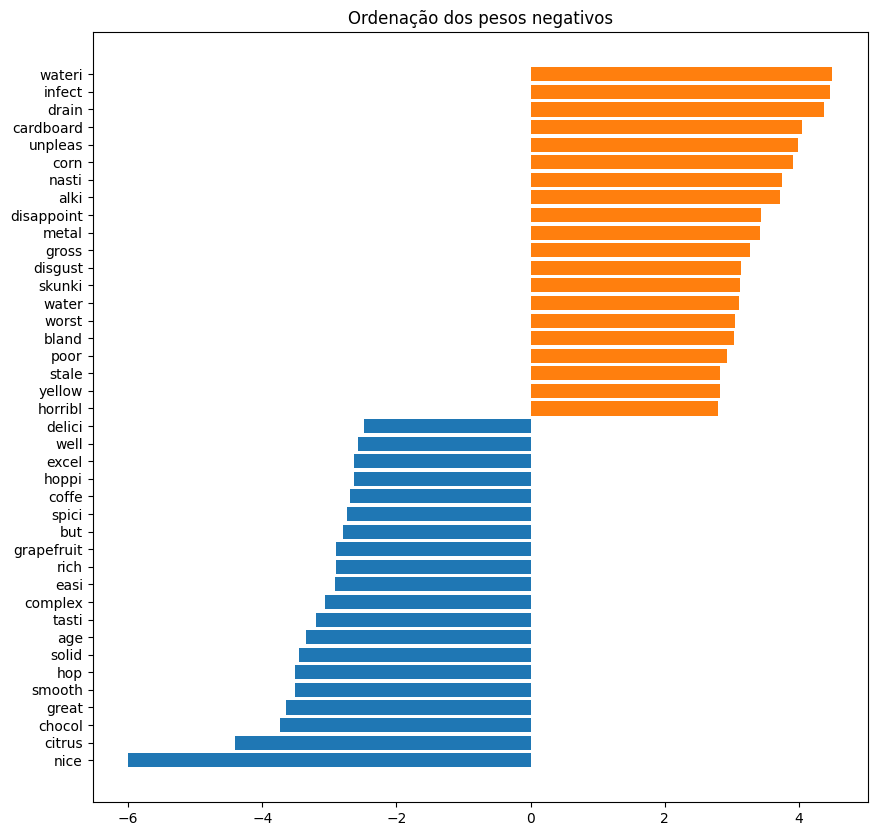

In [63]:
w_pos = model_log_regress_pos.coef_
w_pos = w_pos.squeeze()
idx_pos = np.argsort(w_pos)
print('Numero de dimensões resultantes para classificação: ', np.sum(w_pos != 0))
voc_pos = [tokens_teste[i] for i in idx_pos]
print('Palavras mais relevantes para classificação negativa: ', voc_pos[50:])
print('Palavras mais relevantes para classificação positiva: ', voc_pos[-50:])

w_neg = model_log_regress_neg.coef_
w_neg = w_neg.squeeze()
idx_pos = np.argsort(w_neg)
print('Numero de dimensões resultantes para classificação: ', np.sum(w_neg != 0))
voc_neg = [tokens_teste[i] for i in idx_pos]
print('Palavras mais relevantes para classificação negativa: ', voc_neg[50:])
print('Palavras mais relevantes para classificação positiva: ', voc_neg[-50:])


## Plot dos dados
plt.figure(figsize=(10, 10))
plt.title('Ordenação dos pesos positivos')
plt.barh(voc_pos[:20], w_pos[idx_pos][:20])
plt.barh(voc_pos[-20:], w_pos[idx_pos][-20:])
plt.axis('equal')
plt.show()

plt.figure(figsize=(10, 10))
plt.title('Ordenação dos pesos negativos')
plt.barh(voc_neg[:20], w_neg[idx_pos][:20])
plt.barh(voc_neg[-20:], w_neg[idx_pos][-20:])
plt.axis()
plt.show()


Efetuaremos a matriz de confusão e o recall para verificação adicional dos dados.

Espera-se que sejam demonstrados uma maior taxa de acertos (diagonal principal) e um valor de recall baixo devido a, respetivamente, o score elevado na classificação e a uma maior presença da classe 0 do que a classe 1.

In [16]:
## Recall para efeitos de comparação

# Prever os dados de teste
y_pred_pos = model_log_regress_pos.predict(critica_tfidf_teste)
y_pred_neg = model_log_regress_neg.predict(critica_tfidf_teste)

# Efetuar recall
recall_pos = recall_score(classe_ts_bin_pos, y_pred_pos)
recall_neg = recall_score(classe_ts_bin_neg, y_pred_neg)

print('Recall positivo: ', recall_pos)
print('Recall negativo: ', recall_neg)

Recall positivo:  0.10081008100810081
Recall negativo:  0.20090572251955538


Matriz de confusão positiva: 
 [[23786   103]
 [  999   112]]
Matriz de confusão negativa: 
 [[22435   136]
 [ 1941   488]]


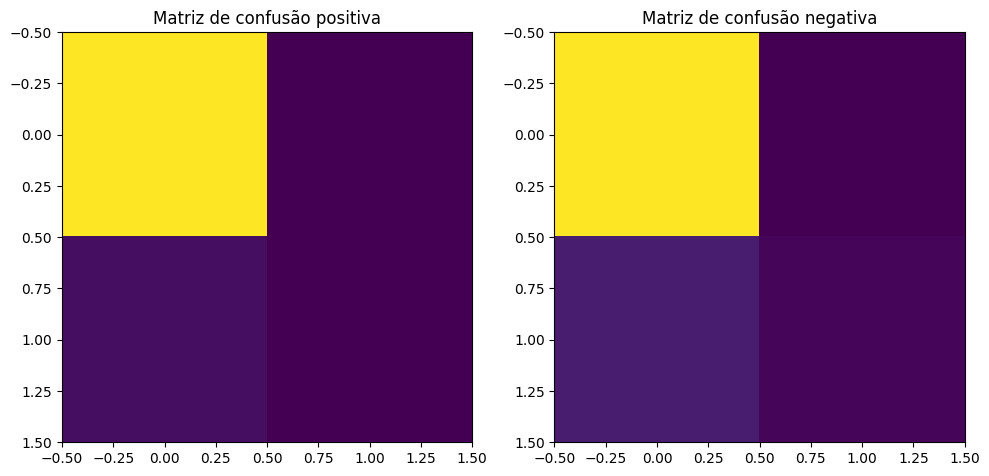

In [18]:
## Matriz de confusão

cm_pos = print_confusion_matrix(classe_ts_bin_pos, y_pred_pos)
cm_neg = print_confusion_matrix(classe_ts_bin_neg, y_pred_neg)

print('Matriz de confusão positiva: \n', cm_pos)
print('Matriz de confusão negativa: \n', cm_neg)

# Plot da matriz
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(cm_pos)    
plt.title('Matriz de confusão positiva')
plt.subplot(1, 2, 2)
plt.imshow(cm_neg)
plt.title('Matriz de confusão negativa')
plt.tight_layout()
plt.show()

Verifica-se através da diagonal principal que a taxa de acertos (verdadeiros positivos) é bastante elevada, logo é comprovada a eficácia do classificador. Em 25000 críticas de teste, para o caso positivo temos 23898 acertos e, para o caso negativo, 22923 acertos. 

O resultado do recall comprova que o classificador está a dar um peso maior aos valores a 0, já que são a maioria, daí o seu resultado tão baixo nas percentagens das primeira e segunda dezenas.

### KNN (K-Nearest Neighbors) <a name="knnbin"></a>

O algoritmo de classificação KNN (K-Nearest Neighbors, em português 'K-Vizinhos Mais Próximos') é um método de aprendizagem supervisionada. Este algoritmo pega num objeto a classificar e, tendo em conta os K vizinhos mais próximos de si, atribui-lhe a classe dos tais vizinhos, classificando-o como parte dessa mesma vizinhança. 
- Esta proximidade à vizinhança é calculada através de uma métrica de distância (sendo a distância de `Minkowski` a distância usada por defeito), sendo posteriormente determinada a classe do objeto a classificar através da maioria dos 'K-Vizinhos' 

Será usada a seguinte função:

In [38]:
def apply_knn_classifier(number_neigh):
    """ @data -> matriz com o tf-idf de cada documento
        @target -> lista com a classificação binária de cada review

        Retorna um modelo knn treinado com os dados fornecidos
    """
    model = KNeighborsClassifier(n_neighbors=number_neigh)
    return model

Para determinar os melhores valores da vizinhança, de modo a classificar no final os verdadeiros dados de treino e teste, correr-se-à um teste a verificar qual a melhor pontuação com base no valor de vizinhos.

Será de notar que quanto <b>menor</b> for o valor dos vizinhos, maior é a chance de ocorrer <i>overfitting</i>, sendo que é importante encontrar o meio termo ideal do hiper-parâmetro.

In [36]:
## Testar o modelo knn com diferentes valores de k

k_list = [1, 3, 5, 7, 9, 11]

for k in k_list:
    print('Iteração no número de vizinhos atual: ', k)
    model = apply_knn_classifier(k).fit(rev_tfidf_treino_small, ytr_bin_pos)
    score_treino = model.score(rev_tfidf_treino_small, ytr_bin_pos)
    print('Score do modelo knn com tf-idf no treino: ', score_treino)
    score_teste = model.score(rev_tfidf_teste_small, yts_bin_pos)
    print('Score do modelo knn com tf-idf no teste: ', score_teste)

Iteração no número de vizinhos atual:  1
Score do modelo knn com tf-idf no treino:  1.0
Score do modelo knn com tf-idf no teste:  0.9002222222222223
Iteração no número de vizinhos atual:  3
Score do modelo knn com tf-idf no treino:  0.9466285714285714
Score do modelo knn com tf-idf no teste:  0.9246222222222222
Iteração no número de vizinhos atual:  5
Score do modelo knn com tf-idf no treino:  0.9398095238095238
Score do modelo knn com tf-idf no teste:  0.9289777777777778
Iteração no número de vizinhos atual:  7
Score do modelo knn com tf-idf no treino:  0.9371619047619048
Score do modelo knn com tf-idf no teste:  0.9308888888888889
Iteração no número de vizinhos atual:  9
Score do modelo knn com tf-idf no treino:  0.9360571428571428
Score do modelo knn com tf-idf no teste:  0.9313333333333333
Iteração no número de vizinhos atual:  11
Score do modelo knn com tf-idf no treino:  0.9353142857142858
Score do modelo knn com tf-idf no teste:  0.9314666666666667


Tendo em conta os resultados apresentados acima, verifica-se que o melhor número de K será `K = 11`. Isto porque não só apresenta pontuações bastante favoráveis, mas também ao verificar os resultados de treino e teste, são os resultados cujos valores estão <b>o mais aproximados possível</b>.

In [39]:
print('A aplicar os classificadores...')
model_knn_pos = apply_knn_classifier(11).fit(critica_tfidf_treino, classe_tr_bin_pos)
model_knn_neg = apply_knn_classifier(11).fit(critica_tfidf_treino, classe_tr_bin_neg)
print('Classificadores aplicados!\n')

# Prever os dados de teste
print('A prever os dados de teste...')
y_pred_pos = model_knn_pos.predict(critica_tfidf_teste)
y_pred_neg = model_knn_neg.predict(critica_tfidf_teste)
print('Dados previstos!\n')

# Verificar as pontuações
print('A verificar as pontuações...')
score_train_pos = model_knn_pos.score(critica_tfidf_treino, classe_tr_bin_pos)
score_train_neg = model_knn_neg.score(critica_tfidf_treino, classe_tr_bin_neg)
score_test_pos = model_knn_pos.score(critica_tfidf_teste, classe_ts_bin_pos)
score_test_neg = model_knn_neg.score(critica_tfidf_teste, classe_ts_bin_neg)
print('Pontuações verificadas!\n')

A aplicar os classificadores...
Classificadores aplicados!

A prever os dados de teste...
Dados previstos!

A verificar as pontuações...
Pontuações verificadas!



In [42]:
print('Previsão de teste positivos: ', y_pred_pos)
print('Previsão de teste negativos: ', y_pred_neg)
print('Score treino positivo: ', score_train_pos)
print('Score treino negativo: ', score_train_neg)
print('Score teste positivo: ', score_test_pos)
print('Score teste negativo: ', score_test_neg)

Previsão de teste positivos:  [0 0 0 ... 0 0 0]
Previsão de teste negativos:  [0 0 0 ... 0 0 0]
Score treino positivo:  0.93456
Score treino negativo:  0.95728
Score teste positivo:  0.95556
Score teste negativo:  0.90488


Verifica-se que a classificação dos dados de teste em relação aos de treino possui uma pontuação favorável, já que ambas estão perto uma da outra. Assim verificamos que não se encontra em <i>overfitting</i> e o modelo está em bom funcionamento.

Matriz de confusão positiva: 
 [[23872    17]
 [ 1094    17]]
Matriz de confusão negativa: 
 [[22551    20]
 [ 2358    71]]


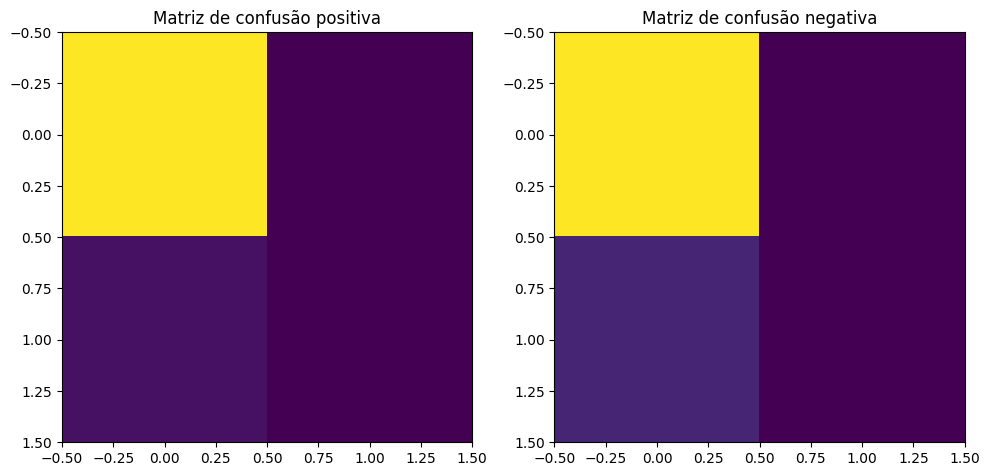

In [40]:
## Matriz de confusão

cm_pos = print_confusion_matrix(classe_ts_bin_pos, y_pred_pos)
cm_neg = print_confusion_matrix(classe_ts_bin_neg, y_pred_neg)

print('Matriz de confusão positiva: \n', cm_pos)
print('Matriz de confusão negativa: \n', cm_neg)

## Demonstração

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(cm_pos)
plt.title('Matriz de confusão positiva')
plt.subplot(1, 2, 2)
plt.imshow(cm_neg)
plt.title('Matriz de confusão negativa')
plt.tight_layout()
plt.show()

Mais uma vez o valor do recall é indicativo da quantidade de 0's que prevalecem como classe do que a minoria de 1's em ambas as listas. Ora aplicando isto à previsão da classe pós clasificação com base na k-vizinhança, os valores baixíssimos são esperados.

In [41]:
## Recall dos dados

recall_pos = recall_score(classe_ts_bin_pos, y_pred_pos)
recall_neg = recall_score(classe_ts_bin_neg, y_pred_neg)

print('Recall positivo: ', recall_pos)
print('Recall negativo: ', recall_neg)

Recall positivo:  0.0153015301530153
Recall negativo:  0.029230135858377932


### SVM <a name="svmbin"></a>

Uma SVM (Support Vector Machine), em português uma máquina de suporte vetorial, é um algoritmo de aprendizagem supervisionada cujo objetivo é encontrar a melhor divisão dos dados, através de um hiper-plano, tentando maximizar a margem entre cada classe de dados. A dimensão do hiper-plano é afetada pela dimensão de dados existentes.

As SVM usam vetores de suporte, vetores mais próximos da margem das classes, influenciando a posição e orientação do hiper-plano. Estes vetores maximizam a margem do classificador, sendo estes pontos cruciais à construção da máquina em si.

Este algoritmo é bastante eficaz na classificação dos dados, apresentando taxas de acerto altamente satisfatórias, no entanto é mais pesado que os outros dois algoritmos desenvolvidos ao longo deste documento sendo que para facilitar a sua execução com a quantidade elevada de dados, fez-se uso do `LinearSVC()`, sendo este até mais flexível na escolha dos hiper-parâmetros.

In [36]:
def apply_svc_classifier(kernel_type):
    """ @data -> matriz com o tf-idf de cada documento
        @target -> lista com a classificação binária de cada review

        Retorna um modelo svc treinado com os dados fornecidos
    """
    model = SVC(kernel=kernel_type)
    return model

In [37]:
## Criar um vocabulário mais pequeno, partindo do que já teve split

Xtrein_svm, X_teste_svm, y_trein_svm, y_teste_svm = train_test_split(reviews_treino, ytr, test_size=0.3, random_state=42)
Xtrein_svm = Xtrein_svm[:5000]
X_teste_svm = X_teste_svm[:2500]
y_trein_svm = y_trein_svm[:5000]
y_teste_svm = y_teste_svm[:2500]

# Binário
ytr_bin_pos_svm, ytr_bin_neg_svm = transform_rating_to_binary(y_trein_svm)
yts_bin_pos_svm, yts_bin_neg_svm = transform_rating_to_binary(y_teste_svm)

# Limpar o documento
Xtrein_svm_clean = clean_document(Xtrein_svm, r'[^a-zA-Z\u00C0-\u00FF]+')
Xteste_svm_clean = clean_document(X_teste_svm, r'[^a-zA-Z\u00C0-\u00FF]+')

# Stemmer
Xtrein_svm_stem = stemmer(Xtrein_svm_clean, 3)
Xteste_svm_stem = stemmer(Xteste_svm_clean, 3)

# Aplicar tfidf
tokens_trein_svm, Xtrein_svm_tfidf = tfidf(3, r'\b\w\w\w+\b', Xtrein_svm_stem, Xtrein_svm_stem)
tokens_teste_svm, Xteste_svm_tfidf = tfidf(3, r'\b\w\w\w+\b', Xtrein_svm_stem, Xteste_svm_stem)

In [ ]:
## Testar o modelo svc com diferentes valores de kernel
kernel_list = ['rbf', 'linear']

for kernel in kernel_list:
    print('Iteração no kernel atual: ', kernel)
    model = apply_svc_classifier(kernel).fit(Xtrein_svm_tfidf, ytr_bin_pos_svm)
    score_treino = model.score(Xtrein_svm_tfidf, ytr_bin_pos_svm)
    print('Score do modelo svc com tf-idf no treino: ', score_treino)
    score_teste = model.score(Xteste_svm_tfidf, yts_bin_pos_svm)
    print('Score do modelo svc com tf-idf no teste: ', score_teste)

Iteração no kernel atual:  rbf


Score do modelo svc com tf-idf no treino:  0.9546
Score do modelo svc com tf-idf no teste:  0.926
Iteração no kernel atual:  linear
Score do modelo svc com tf-idf no treino:  0.9388
Score do modelo svc com tf-idf no teste:  0.9264


Analisando os resultados acima, verifica-se que o score mais adequado, ou seja, os resultados que mais aproximam os conjuntos de teste e de treino um do outro, são os do `kernel=linear`. 

Embora estes testes sejam satisfatórios, não seria correto usar o SVC regular para a classificação dos dados presentes no projeto, já que o tempo consumido seria elevadíssimo. Assim, usar-se-à o LinearSVC.

In [47]:
def apply_linear_svc(weight):
    """ @data -> matriz com o tf-idf de cada documento
        @target -> lista com a classificação binária de cada review

        Retorna um modelo svc treinado com os dados fornecidos
    """
    model = LinearSVC(penalty='l2', class_weight=weight)
    return model

Para definir o treino com a máquina de suporte vetorial, `LinearSVC()` definiu-se o parâmetro de 'balanced'.
- Isto deve-se ao facto de ambas as listas de classes (positivas e negativas) apresentam um desiquilíbrio relativamente à quantidade de 0's e 1's existentes (ex: na lista de positivos temos oito 0s e dois 1s)

In [48]:
## Aplicar o modelo svc aos dados com o kernel linear
print('A aplicar os modelos SVM...')
print('Modelo Positivo em treino...')
model_svc_pos = apply_linear_svc('balanced').fit(critica_tfidf_treino, classe_tr_bin_pos)
print('Treinado!', '\n', 'Modelo Negativo em treino...')
model_svc_neg = apply_linear_svc('balanced').fit(critica_tfidf_treino, classe_tr_bin_neg)
print('Treinado!')
print('Modelos treinados! \n')

# Prever os dados de teste
print('A prever os dados...')
y_pred_pos = model_svc_pos.predict(critica_tfidf_teste)
y_pred_neg = model_svc_neg.predict(critica_tfidf_teste)
print('Dados previstos! \n')

# Verificar as pontuações
print('A verificar as pontuações...')
score_train_pos = model_svc_pos.score(critica_tfidf_treino, classe_tr_bin_pos)
score_train_neg = model_svc_neg.score(critica_tfidf_treino, classe_tr_bin_neg)
score_test_pos = model_svc_pos.score(critica_tfidf_teste, classe_ts_bin_pos)
score_test_neg = model_svc_neg.score(critica_tfidf_teste, classe_ts_bin_neg)
print('Pontuações verificadas! \n')


A aplicar os modelos SVM...
Modelo Positivo em treino...


C:\Users\h_e_m\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Treinado! 
 Modelo Negativo em treino...


C:\Users\h_e_m\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Treinado!
Modelos treinados! 

A prever os dados...
Dados previstos! 

A verificar as pontuações...
Pontuações verificadas! 



In [45]:
## Demonstrações
print('Previsão de teste positivos: ', y_pred_pos)
print('Previsão de teste negativos: ', y_pred_neg)
print('Score treino positivo: ', score_train_pos)
print('Score treino negativo: ', score_train_neg)
print('Score teste positivo: ', score_test_pos)
print('Score teste negativo: ', score_test_neg)

Previsão de teste positivos:  [0 0 0 ... 0 0 0]
Previsão de teste negativos:  [0 0 0 ... 0 1 0]
Score treino positivo:  0.8925733333333333
Score treino negativo:  0.9413466666666667
Score teste positivo:  0.8824
Score teste negativo:  0.87068


Verificam-se resultados bastante satisfatórios na classificação dos dados, sendo que estão bastante próximos uns dos outros os resultados dos conjuntos de teste e treino, não entrando em overfitting.

Matriz de confusão para o modelo positivo: 
 [[21452  2437]
 [  503   608]] 

Matriz de confusão para o modelo negativo: 
 [[20185  2386]
 [  847  1582]]


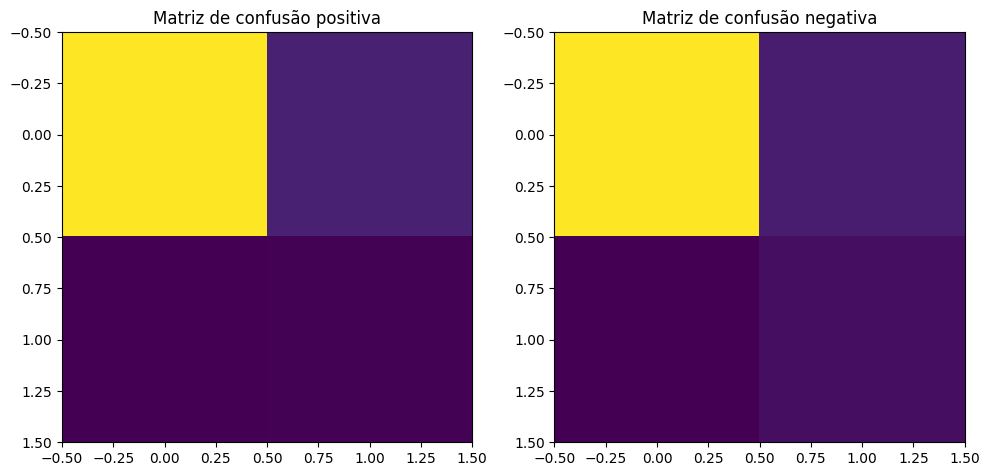

In [59]:
## Visualizar a matriz de confusão

print('Matriz de confusão para o modelo positivo: \n', print_confusion_matrix(classe_ts_bin_pos, y_pred_pos), '\n')
print('Matriz de confusão para o modelo negativo: \n', print_confusion_matrix(classe_ts_bin_neg, y_pred_neg))

# Plot da matriz de confusão

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(print_confusion_matrix(classe_ts_bin_pos, y_pred_pos))
plt.title('Matriz de confusão positiva')
plt.subplot(1, 2, 2)
plt.imshow(print_confusion_matrix(classe_ts_bin_neg, y_pred_neg))
plt.title('Matriz de confusão negativa')
plt.tight_layout()
plt.show()


Numero de dimensões resultantes para classificação:  14977
Palavras mais relevantes para classificação negativa:  ['pacif', 'fierc', 'twangi', 'fake', 'letdown', 'brash', 'infect', 'space', 'odd', 'remnant', 'foreign', 'ben', 'blankboy', 'potenti', 'heartland', 'band', 'dissapoint', 'daknol', 'learn', 'unfortun', 'needless', 'swear', 'leagu', 'ship', 'faintest', 'moka', 'tavern', 'vapour', 'schwarzbier', 'countri', 'likewis', 'pud', 'earthy', 'sub', 'tequila', 'blacken', 'downhil', 'bitbucket', 'rose', 'miller', 'swig', 'wors', 'caress', 'sand', 'conclus', 'worker', 'girl', 'gray', 'overcom', 'radar', 'durham', 'spare', 'scratch', 'truth', 'lose', 'sizzl', 'bad', 'hopscotch', 'teh', 'skunk', 'zappa', 'gargantuan', 'erupt', 'citri', 'select', 'intensifi', 'cooper', 'som', 'confus', 'vapor', 'undrink', 'oakbluff', 'norristown', 'faststi', 'elev', 'ecru', 'stine', 'worthwhil', 'bbb', 'drbayern', 'dak', 'charlottesvill', 'miniscul', 'death', 'counterpoint', 'sizabl', 'chalk', 'overlay', 'r

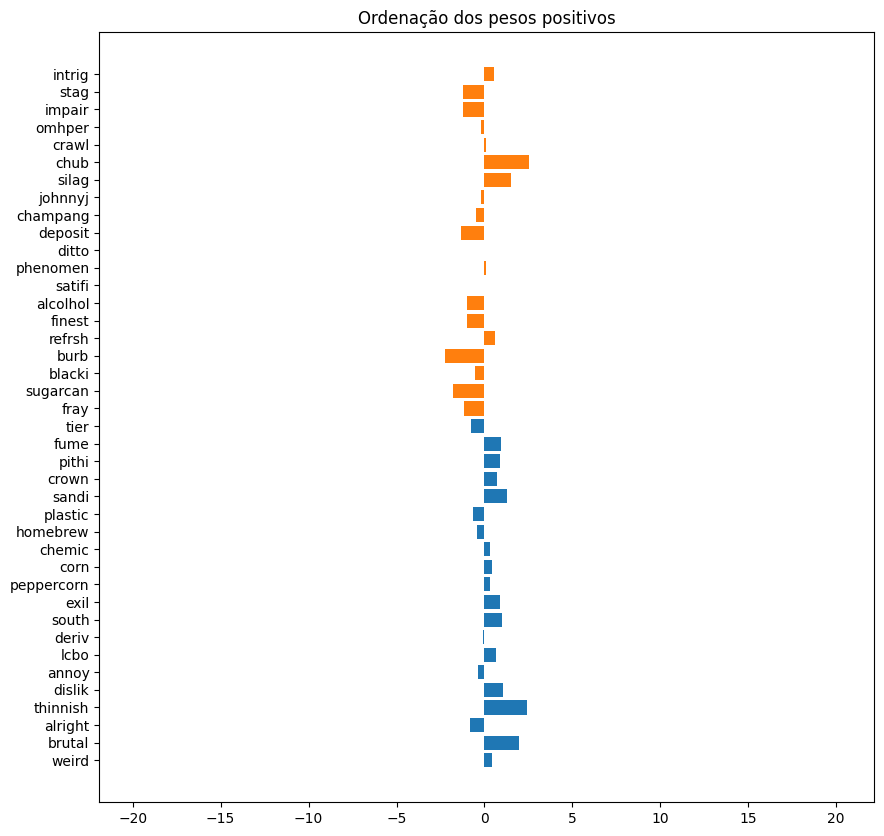

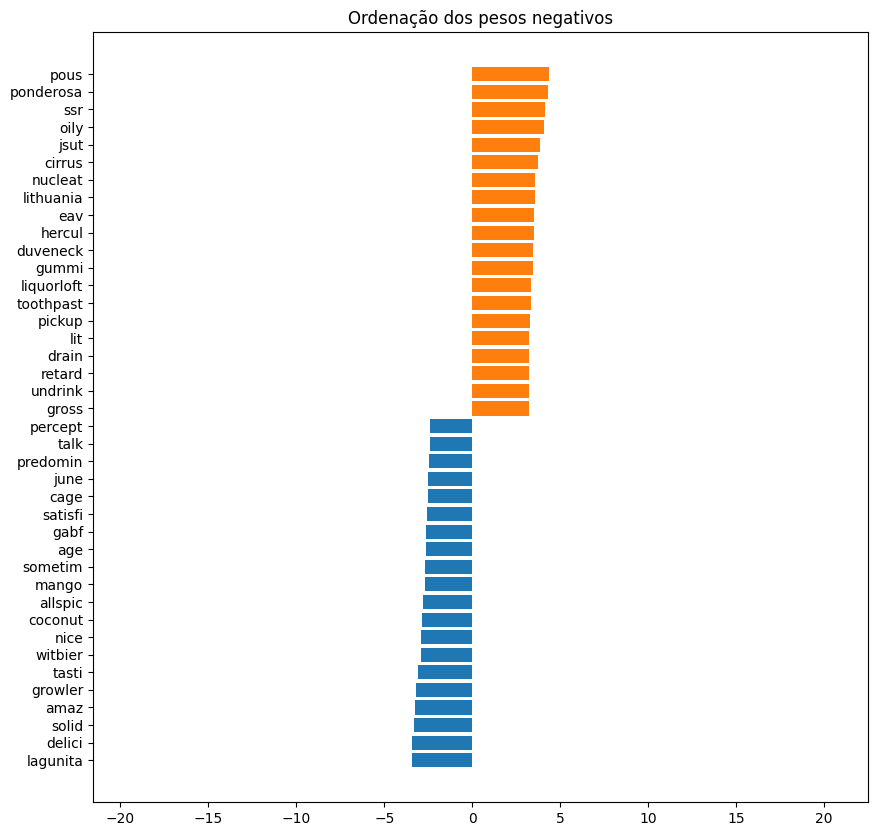

In [61]:
w_pos = model_svc_pos.coef_
w_pos = w_pos.squeeze()
idx_pos = np.argsort(w_pos)
print('Numero de dimensões resultantes para classificação: ', np.sum(w_pos != 0))
voc_pos = [tokens_teste[i] for i in idx_pos]
print('Palavras mais relevantes para classificação negativa: ', voc_pos[50:])
print('Palavras mais relevantes para classificação positiva: ', voc_pos[-50:])

w_neg = model_svc_neg.coef_
w_neg = w_neg.squeeze()
idx_pos = np.argsort(w_neg)
print('Numero de dimensões resultantes para classificação: ', np.sum(w_neg != 0))
voc_neg = [tokens_teste[i] for i in idx_pos]
print('Palavras mais relevantes para classificação negativa: ', voc_neg[50:])
print('Palavras mais relevantes para classificação positiva: ', voc_neg[-50:])


## Plot dos dados
plt.figure(figsize=(10, 10))
plt.title('Ordenação dos pesos positivos')
plt.barh(voc_pos[:20], w_pos[idx_pos][:20])
plt.barh(voc_pos[-20:], w_pos[idx_pos][-20:])
plt.axis('equal')
plt.show()

plt.figure(figsize=(10, 10))
plt.title('Ordenação dos pesos negativos')
plt.barh(voc_neg[:20], w_neg[idx_pos][:20])
plt.barh(voc_neg[-20:], w_neg[idx_pos][-20:])
plt.axis('equal')
plt.show()


Sabendo que temos 25000 críticas, ambas as matrizes de confusão apresenta resultados bastante satisfatórios.

A quantidade de <b>falsos positivos</b> e de falsos negativos é suficientemente baixa para demonstrar sucesso, sendo que a taxa de acertos (TP + TF) apresenta-se bastante elevada, aproximando-se até do número total de críticas de teste.

Calculando o `recall`, será possível verificar que o valor do recall é menor do que o score. Isto demonstra-se pelo facto do modelo ser melhor a identificar os resultados negativos (0) do que positivos (1).
- Ora isto resulta do facto de haver mais 0's do que 1's nas classes  

In [41]:
## Recall
 
recall_pos_svc = recall_score(classe_ts_bin_pos, y_pred_pos)
recall_neg_svc = recall_score(classe_ts_bin_neg, y_pred_neg)

print('Recall positivo: ', recall_pos_svc)
print('Recall negativo: ', recall_neg_svc)

Recall positivo:  0.5472547254725473
Recall negativo:  0.6512968299711815


<hr>

## Classificação Multi-Classe <a name="mult"></a>

<i>"Prever a pontuação de três aspetos das críticas (smell, taste e overall). Neste ponto,
treine e avalie os classificadores com os dados de treino e verifique se as estimativas do
desempenho condizem com os resultados obtidos no conjunto de teste." </i>

Neste ponto, irão ser criadas três listas com classes, diferentes, para poder verificar a classificação com base em diferentes categorias das críticas: 'smell', 'taste' e 'overall'.
- 'smell' e 'taste' possuem classificações de 1 até 5
- 'overall' possui classificações de 1 a 10

Os fundamentos de uma classificaçao multi-classe apoiam-se sobre o facto dos dados, ao contrário da classificação binária que só possuía duas classes possíveis a atribuir ao texto (1 ou 0), possuírem várias classes referentes ao seu texto, ou seja, uma crítica pode ter um valor no intervalo [1; 5] (no caso de 'smell' ou 'taste') ou de [1; 10] (no caso de 'overall').
- Ou seja, em multi-classe, aplicando um exemplo prático, podemos classificar uma forma tri-dimensional como sendo um cubo, pirâmide, esfera ou paralelepípedo, havendo três ou mais possibilidades de classificação


Assim, para começar, necessita-se de uma função que transforme as críticas recebidas em quatro listas:
- 1 - Texto da crítica
- 2 - Lista com classificações baseadas em cheiro ('smell')
- 3 - Lista com classificações baseadas em gosto ('taste')
- 4 - Lista com classificações baseadas em pontuação geral ('overall')

In [22]:
## Iremos usar multi-classe para classificar as reviews de cerveja

def transform_rating_to_multiclass(review_list):
    """ @classes -> lista com a classificação atribuída às cervejas

        Nesta função iremos percorrer os dicionários das reviews, por todas as keys, 
        para encontrar as classes referentes a 'smell', 'taste' e 'overall'.
        Irão ser retornadas 3 listas com as classificações de cada review para cada:
            1 - texto da review
            2 - smell
            3 - taste
            4 - overall
    """
    classes_texto = []
    classes_smell = []
    classes_taste = []
    classes_overall = []
    for key, valor in review_list.items():
        classes_texto.append(valor['review'])
        classes_smell.append(valor['smell'])
        classes_taste.append(valor['taste'])
        classes_overall.append(valor['overall'])
    return classes_texto, classes_smell, classes_taste, classes_overall

Obtendo os resultados desta função, poderemos começar a processar o vocabulário. Ora, sabendo que o texto não varia dos testes realizados num momento de pré-processamento anterior, iremos utilizar o mesmo número mínimo de frequência de termo no documento, número mínimo de caracteres por palavra e expressões regulares.

<b> Neste momento inicial, será usado um vocabulário reduzido para deteção dos melhores hiper-parâmetros dos classificadores a usar.

In [ ]:
## Obter review e classes para multiclasse

reviews_texto_treino, classes_smell_treino, classes_taste_treino, classes_overall_treino = transform_rating_to_multiclass(rev_treino)
reviews_texto_teste, classes_smell_teste, classes_taste_teste, classes_overall_teste = transform_rating_to_multiclass(rev_teste)

## Test train split para que se possa achar os melhores valores em testes
reviews_texto_treino_split_ov, reviews_texto_teste_split_ov, \
    ytr_split_ov, yts_split_ov = train_test_split(reviews_texto_treino, classes_overall_treino, test_size=0.3, random_state=42)

reviews_texto_treino_split_sm, reviews_texto_teste_split_sm, \
    ytr_split_sm, yts_split_sm = train_test_split(reviews_texto_treino, classes_smell_treino, test_size=0.3, random_state=42)

reviews_texto_treino_split_ts, reviews_texto_teste_split_ts, \
    ytr_split_ts, yts_split_ts = train_test_split(reviews_texto_treino, classes_taste_treino, test_size=0.3, random_state=42)

## Limpar o documento
reviews_texto_treino_split_ov = clean_document(reviews_texto_treino_split_ov, r'[^a-zA-Z\u00C0-\u00FF]+')
reviews_texto_teste_split_ov = clean_document(reviews_texto_teste_split_ov, r'[^a-zA-Z\u00C0-\u00FF]+')

reviews_texto_treino_split_sm = clean_document(reviews_texto_treino_split_sm, r'[^a-zA-Z\u00C0-\u00FF]+')
reviews_texto_teste_split_sm = clean_document(reviews_texto_teste_split_sm, r'[^a-zA-Z\u00C0-\u00FF]+')

reviews_texto_treino_split_ts = clean_document(reviews_texto_treino_split_ts, r'[^a-zA-Z\u00C0-\u00FF]+')
reviews_texto_teste_split_ts = clean_document(reviews_texto_teste_split_ts, r'[^a-zA-Z\u00C0-\u00FF]+')

## Stemmer
reviews_texto_treino_split_ov = stemmer(reviews_texto_treino_split_ov, 3)
reviews_texto_teste_split_ov = stemmer(reviews_texto_teste_split_ov, 3)

reviews_texto_treino_split_sm = stemmer(reviews_texto_treino_split_sm, 3)
reviews_texto_teste_split_sm = stemmer(reviews_texto_teste_split_sm, 3)

reviews_texto_treino_split_ts = stemmer(reviews_texto_treino_split_ts, 3)
reviews_texto_teste_split_ts = stemmer(reviews_texto_teste_split_ts, 3)

In [26]:
## Aplicar tfidf
tokens_trein_ov_reduced, reviews_texto_treino_tfidf_ov_reduced = tfidf(3, r'\b\w\w\w+\b', reviews_texto_treino_split_ov, reviews_texto_treino_split_ov)
tokens_teste_ov_reduced, reviews_texto_teste_tfidf_ov_reduced = tfidf(3, r'\b\w\w\w+\b', reviews_texto_treino_split_ov, reviews_texto_teste_split_ov)

tokens_trein_sm_reduced, reviews_texto_treino_tfidf_sm_reduced = tfidf(3, r'\b\w\w\w+\b', reviews_texto_treino_split_sm, reviews_texto_treino_split_sm)
tokens_teste_sm_reduced, reviews_texto_teste_tfidf_sm_reduced = tfidf(3, r'\b\w\w\w+\b', reviews_texto_treino_split_sm, reviews_texto_teste_split_sm)

tokens_trein_ts_reduced, reviews_texto_treino_tfidf_ts_reduced = tfidf(3, r'\b\w\w\w+\b', reviews_texto_treino_split_ts, reviews_texto_treino_split_ts)
tokens_teste_ts_reduced, reviews_texto_teste_tfidf_ts_reduced = tfidf(3, r'\b\w\w\w+\b', reviews_texto_treino_split_ts, reviews_texto_teste_split_ts)


### Regressão Logística <a name="reglogmult"></a>

In [40]:
## Procura dos melhores valores de C e penalty para o modelo de regressão logistica

## Para overall
print('Processamento para Overall... \n')
best_penalty_ov, best_C_ov, best_score_ov = find_best_values_log_regress(reviews_texto_treino_tfidf_ov_reduced, ytr_split_ov)
print('Melhor penalização: ', best_penalty_ov)
print('Melhor C: ', best_C_ov)
print('Melhor score: ', best_score_ov, '\n')

## Para smell
print('Processamento para Smell... \n')
best_penalty_sm, best_C_sm, best_score_sm = find_best_values_log_regress(reviews_texto_treino_tfidf_sm_reduced, ytr_split_sm)
print('Melhor penalização: ', best_penalty_sm)
print('Melhor C: ', best_C_sm)
print('Melhor score: ', best_score_sm, '\n')

## Para taste
print('Processamento para Taste... \n')
best_penalty_ts, best_C_ts, best_score_ts = find_best_values_log_regress(reviews_texto_treino_tfidf_ts_reduced, ytr_split_ts)
print('Melhor penalização: ', best_penalty_ts)
print('Melhor C: ', best_C_ts)
print('Melhor score: ', best_score_ts, '\n')

Processamento para Overall... 

Iteração na penalização atual:  l1
Iteração no C atual:  0.001
Iteração no C atual:  0.1
Iteração no C atual:  1
Iteração na penalização atual:  l2
Iteração no C atual:  0.001
Iteração no C atual:  0.1
Iteração no C atual:  1
Melhor penalização:  l2
Melhor C:  1
Melhor score:  0.46554285714285715 

Processamento para Smell... 

Iteração na penalização atual:  l1
Iteração no C atual:  0.001
Iteração no C atual:  0.1
Iteração no C atual:  1
Iteração na penalização atual:  l2
Iteração no C atual:  0.001
Iteração no C atual:  0.1
Iteração no C atual:  1
Melhor penalização:  l2
Melhor C:  1
Melhor score:  0.5733904761904762 

Processamento para Taste... 

Iteração na penalização atual:  l1
Iteração no C atual:  0.001
Iteração no C atual:  0.1
Iteração no C atual:  1
Iteração na penalização atual:  l2
Iteração no C atual:  0.001
Iteração no C atual:  0.1
Iteração no C atual:  1
Melhor penalização:  l2
Melhor C:  1
Melhor score:  0.5923619047619048 



Assim, obtêm-se os seguintes melhores valores de C e de penalização para cada classe:

|Classe | C     | Penalização |
|-------|----------|-----|
| Smell  | 1  | l2  | 
| Taste  |  1 | l2  | 
| Overall| 1 | l2  | 


É conveniente que todos os testes tenham apresentado melhor C = 1 e melhor penalização = 'l2', sendo que assim não serão necessários ajustes diferentes à Regressão Logística.

Aplicar-se-ão, então, os valores obtidos ao modelo:

In [41]:
## Aplicar a regressão logística a cada lista de classes (smell, taste, overall) com reviews completas

best_penalty_for_sm = best_penalty_sm
best_C_for_sm = best_C_sm

best_penalty_for_ts = best_penalty_ts
best_C_for_ts = best_C_ts

best_penalty_for_ov = best_penalty_ov
best_C_for_ov = best_C_ov

## Smell
print('A aplicar os modelos de regressão logística... --> Por ordem: smell, taste e overall \n')
print('Modelo Smell em treino...')
model_log_regress_sm = apply_best_log_regress(best_penalty_for_sm, best_C_for_sm)
model_log_regress_sm.fit(reviews_texto_treino_tfidf_sm_reduced, ytr_split_sm)
print('Treinado!', '\n', 'Modelo Smell em teste...')

# Prever os dados de teste
print('A prever os dados...')
y_pred_sm = model_log_regress_sm.predict(reviews_texto_teste_tfidf_sm_reduced)
print('Dados previstos! \n')

# Verificar as pontuações
print('A verificar as pontuações...')
score_train_sm = model_log_regress_sm.score(reviews_texto_treino_tfidf_sm_reduced, ytr_split_sm)
score_test_sm = model_log_regress_sm.score(reviews_texto_teste_tfidf_sm_reduced, yts_split_sm)
print('Pontuações verificadas! \n', '-'*100)

## Taste
print('Modelo Taste em treino...')
model_log_regress_ts = apply_best_log_regress(best_penalty_for_ts, best_C_for_ts)
model_log_regress_ts.fit(reviews_texto_treino_tfidf_ts_reduced, ytr_split_ts)
print('Treinado!', '\n', 'Modelo Taste em teste...')

# Prever os dados de teste
print('A prever os dados...')
y_pred_ts = model_log_regress_ts.predict(reviews_texto_teste_tfidf_ts_reduced)
print('Dados previstos! \n')

# Verificar as pontuações
print('A verificar as pontuações...')
score_train_ts = model_log_regress_ts.score(reviews_texto_treino_tfidf_ts_reduced, ytr_split_ts)
score_test_ts = model_log_regress_ts.score(reviews_texto_teste_tfidf_ts_reduced, yts_split_ts)
print('Pontuações verificadas! \n', '-'*100)

## Overall
print('Modelo Overall em treino...')
model_log_regress_ov = apply_best_log_regress(best_penalty_for_ov, best_C_for_ov)
model_log_regress_ov.fit(reviews_texto_treino_tfidf_ov_reduced, ytr_split_ov)
print('Treinado!', '\n', 'Modelo Overall em teste...')

# Prever os dados de teste
print('A prever os dados...')
y_pred_ov = model_log_regress_ov.predict(reviews_texto_teste_tfidf_ov_reduced)
print('Dados previstos! \n')

# Verificar as pontuações
print('A verificar as pontuações...')
score_train_ov = model_log_regress_ov.score(reviews_texto_treino_tfidf_ov_reduced, ytr_split_ov)
score_test_ov = model_log_regress_ov.score(reviews_texto_teste_tfidf_ov_reduced, yts_split_ov)
print('Pontuações verificadas! \n', '-'*100)

A aplicar os modelos de regressão logística... --> Por ordem: smell, taste e overall 

Modelo Smell em treino...


Treinado! 
 Modelo Smell em teste...
A prever os dados...
Dados previstos! 

A verificar as pontuações...
Pontuações verificadas! 
 ----------------------------------------------------------------------------------------------------
Modelo Taste em treino...
Treinado! 
 Modelo Taste em teste...
A prever os dados...
Dados previstos! 

A verificar as pontuações...
Pontuações verificadas! 
 ----------------------------------------------------------------------------------------------------
Modelo Overall em treino...
Treinado! 
 Modelo Overall em teste...
A prever os dados...
Dados previstos! 

A verificar as pontuações...
Pontuações verificadas! 
 ----------------------------------------------------------------------------------------------------


In [42]:
## Demonstrações gerais com os valores em tabela
print('Previsão de teste smell: ', y_pred_sm)
print('Previsão de teste taste: ', y_pred_ts)
print('Previsão de teste overall: ', y_pred_ov, '\n')
print('Score treino smell: ', score_train_sm)
print('Score teste smell: ', score_test_sm, '\n')
print('Score treino taste: ', score_train_ts)
print('Score teste taste: ', score_test_ts, '\n')
print('Score treino overall: ', score_train_ov)
print('Score teste overall: ', score_test_ov, '\n')

Previsão de teste smell:  ['3/5' '3/5' '3/5' ... '4/5' '3/5' '4/5']
Previsão de teste taste:  ['3/5' '3/5' '4/5' ... '4/5' '3/5' '4/5']
Previsão de teste overall:  ['4/10' '4/10' '6/10' ... '7/10' '7/10' '7/10'] 

Score treino smell:  0.5733333333333334
Score teste smell:  0.4579111111111111 

Score treino taste:  0.5922666666666667
Score teste taste:  0.4766222222222222 

Score treino overall:  0.4655619047619048
Score teste overall:  0.30084444444444447 



Em tabela, para facilitar a visualização:


| Score     | Treino | Teste    |
|----------|-----|---------------|
| Smell     | 0.5733  | 0.4579    |
| Taste    | 0.5923  |  0.4766|
| Overall  | 0.4656  | 0.3008      |

Assim, realizados os testes para descobrir os melhores hiper-parâmetros, conclui-se que os melhores resultados foram obtidos com os seguintes hiper-parâmetros:
- Penalização = l2
- C = 1

Poderá ser, então, realizada a classificação final com os hiper-parâmetros obtidos. Começar-se-à por redefenir o vocabulário utilizado para o processamento, esquecendo o `test_train_split` utilizado e passando a usar as críticas sem redução de tamanho.

In [ ]:
## Esquecendo o test train split e aplicando à crítica completa

## Limpar o documento
reviews_texto_treino_ov = clean_document(reviews_texto_treino, r'[^a-zA-Z\u00C0-\u00FF]+')
reviews_texto_teste_ov = clean_document(reviews_texto_teste, r'[^a-zA-Z\u00C0-\u00FF]+')

reviews_texto_treino_sm = clean_document(reviews_texto_treino, r'[^a-zA-Z\u00C0-\u00FF]+')
reviews_texto_teste_sm = clean_document(reviews_texto_teste, r'[^a-zA-Z\u00C0-\u00FF]+')

reviews_texto_treino_ts = clean_document(reviews_texto_treino, r'[^a-zA-Z\u00C0-\u00FF]+')
reviews_texto_teste_ts = clean_document(reviews_texto_teste, r'[^a-zA-Z\u00C0-\u00FF]+')

## Stemmer
reviews_texto_treino_ov = stemmer(reviews_texto_treino_ov, 3)
reviews_texto_teste_ov = stemmer(reviews_texto_teste_ov, 3)

reviews_texto_treino_sm = stemmer(reviews_texto_treino_sm, 3)
reviews_texto_teste_sm = stemmer(reviews_texto_teste_sm, 3)

reviews_texto_treino_ts = stemmer(reviews_texto_treino_ts, 3)
reviews_texto_teste_ts = stemmer(reviews_texto_teste_ts, 3)

In [ ]:
## Aplicar tfidf
tokens_trein_ov, reviews_texto_treino_tfidf_ov = tfidf(3, r'\b\w\w\w+\b', reviews_texto_treino_ov, reviews_texto_treino_ov)
tokens_teste_ov, reviews_texto_teste_tfidf_ov = tfidf(3, r'\b\w\w\w+\b', reviews_texto_treino_ov, reviews_texto_teste_ov)

tokens_trein_sm, reviews_texto_treino_tfidf_sm = tfidf(3, r'\b\w\w\w+\b', reviews_texto_treino_sm, reviews_texto_treino_sm)
tokens_teste_sm, reviews_texto_teste_tfidf_sm = tfidf(3, r'\b\w\w\w+\b', reviews_texto_treino_sm, reviews_texto_teste_sm)

tokens_trein_ts, reviews_texto_treino_tfidf_ts = tfidf(3, r'\b\w\w\w+\b', reviews_texto_treino_ts, reviews_texto_treino_ts)
tokens_teste_ts, reviews_texto_teste_tfidf_ts = tfidf(3, r'\b\w\w\w+\b', reviews_texto_treino_ts, reviews_texto_teste_ts)

In [46]:
## Aplicar a regressão logística a cada lista de classes (smell, taste, overall) com reviews completas

## Smell
print('A aplicar os modelos de regressão logística... --> Por ordem: smell, taste e overall \n')
print('Modelo Smell em treino...')
model_log_regress_sm = apply_best_log_regress(best_penalty_ov, best_C_ov)
model_log_regress_sm.fit(reviews_texto_treino_tfidf_sm, classes_smell_treino)
print('Treinado!', '\n', 'Modelo Smell em teste...')

# Prever os dados de teste
print('A prever os dados...')
y_pred_sm = model_log_regress_sm.predict(reviews_texto_teste_tfidf_sm)
print('Dados previstos! \n')

# Verificar as pontuações
print('A verificar as pontuações...')
score_train_sm = model_log_regress_sm.score(reviews_texto_treino_tfidf_sm, classes_smell_treino)
score_test_sm = model_log_regress_sm.score(reviews_texto_teste_tfidf_sm, classes_smell_teste)
print('Pontuações verificadas! \n', '-'*100)

## Taste
print('Modelo Taste em treino...')
model_log_regress_ts = apply_best_log_regress(best_penalty_ov, best_C_ov)
model_log_regress_ts.fit(reviews_texto_treino_tfidf_ts, classes_taste_treino)
print('Treinado!', '\n', 'Modelo Taste em teste...')

# Prever os dados de teste
print('A prever os dados...')
y_pred_ts = model_log_regress_ts.predict(reviews_texto_teste_tfidf_ts)
print('Dados previstos! \n')

# Verificar as pontuações
print('A verificar as pontuações...')
score_train_ts = model_log_regress_ts.score(reviews_texto_treino_tfidf_ts, classes_taste_treino)
score_test_ts = model_log_regress_ts.score(reviews_texto_teste_tfidf_ts, classes_taste_teste)
print('Pontuações verificadas! \n', '-'*100)

## Overall
print('Modelo Overall em treino...')
model_log_regress_ov = apply_best_log_regress(best_penalty_ov, best_C_ov)
model_log_regress_ov.fit(reviews_texto_treino_tfidf_ov, classes_overall_treino)
print('Treinado!', '\n', 'Modelo Overall em teste...')

# Prever os dados de teste
print('A prever os dados...')
y_pred_ov = model_log_regress_ov.predict(reviews_texto_teste_tfidf_ov)
print('Dados previstos! \n')

# Verificar as pontuações
print('A verificar as pontuações...')
score_train_ov = model_log_regress_ov.score(reviews_texto_treino_tfidf_ov, classes_overall_treino)
score_test_ov = model_log_regress_ov.score(reviews_texto_teste_tfidf_ov, classes_overall_teste)
print('Pontuações verificadas! \n', '-'*100)

A aplicar os modelos de regressão logística... --> Por ordem: smell, taste e overall 

Modelo Smell em treino...
Treinado! 
 Modelo Smell em teste...
A prever os dados...
Dados previstos! 

A verificar as pontuações...
Pontuações verificadas! 
 ----------------------------------------------------------------------------------------------------
Modelo Taste em treino...
Treinado! 
 Modelo Taste em teste...
A prever os dados...
Dados previstos! 

A verificar as pontuações...
Pontuações verificadas! 
 ----------------------------------------------------------------------------------------------------
Modelo Overall em treino...
Treinado! 
 Modelo Overall em teste...
A prever os dados...
Dados previstos! 

A verificar as pontuações...
Pontuações verificadas! 
 ----------------------------------------------------------------------------------------------------


In [47]:
## Demonstrações gerais com os valores em tabela
print('Previsão de teste smell: ', y_pred_sm)
print('Previsão de teste taste: ', y_pred_ts)
print('Previsão de teste overall: ', y_pred_ov, '\n')
print('Score treino smell: ', score_train_sm)
print('Score teste smell: ', score_test_sm, '\n')
print('Score treino taste: ', score_train_ts)
print('Score teste taste: ', score_test_ts, '\n')
print('Score treino overall: ', score_train_ov)
print('Score teste overall: ', score_test_ov, '\n')

Previsão de teste smell:  ['3/5' '3/5' '3/5' ... '3/5' '2/5' '3/5']
Previsão de teste taste:  ['3/5' '3/5' '3/5' ... '3/5' '1/5' '3/5']
Previsão de teste overall:  ['4/10' '6/10' '6/10' ... '4/10' '4/10' '5/10'] 

Score treino smell:  0.5659466666666667
Score teste smell:  0.46932 

Score treino taste:  0.5808266666666667
Score teste taste:  0.47644 

Score treino overall:  0.4544533333333333
Score teste overall:  0.30784 



Verifica-se que os valores de acerto para cada classe, num classificador de multi-classe de Regressão Logística, os resultados não são tão bons como na classificação binária. 

Isto deve-se ao facto do classificador ter de corresponder, a várias palavras que aparecem nos dados de texto, as pontuações de cada categoria da crítica. Ou seja, de um modo resumido, a palavra 'melhor' pode estar associada a críticas muito boas, boas ou até mesmo de valores intermédios (ex. uma classificação de '5/10'). Logo, ao tentar atribuir a cada palavra, que apareça de certo modo frequentemente em várias classes, acaba por apresentar uma taxa de erro elevada, tal como se pode verificar na matriz de confusão abaixo.

`Possível Solução`: alterar o hiper-parâmetro do TfIdfVectorizer para que o vocabulário contenha uma frequência mínima de palavra diferente (min_df), no entanto a pontuação não seria, largamente, melhor.

Matriz de confusão para o modelo smell: 
 [[2516 1234 1021  119    8]
 [ 856 1795 2853  416   18]
 [ 364 1096 5075 1530   58]
 [  94  238 2157 2179  161]
 [  42   27  326  649  168]] 

Matriz de confusão para o modelo taste: 
 [[2441 1215 1031  125    8]
 [ 770 1547 2686  375   18]
 [ 334  949 5122 1724   51]
 [  87  185 2183 2590  226]
 [  38   26  288  770  211]] 

Matriz de confusão para o modelo overall: 
 [[ 271    0   84  309  398   34   38   14    5    1]
 [   5   18    0    3   13    4   38   55   64   45]
 [  58    0   57  341  705   55   44   11    2    2]
 [  46    2   51  414 1726  190  185   62   22    1]
 [  28    1   30  304 3264  800  932  285   49    9]
 [  11    2    4   61 1448  732 1142  471   96   10]
 [   4    4    2   45  816  542 1502  787  266   42]
 [   6    2    1   26  427  293 1019  928  417   80]
 [   5   20    1   10  166  123  426  641  410   71]
 [   2   16    0   12   62   41  160  224  249  100]] 



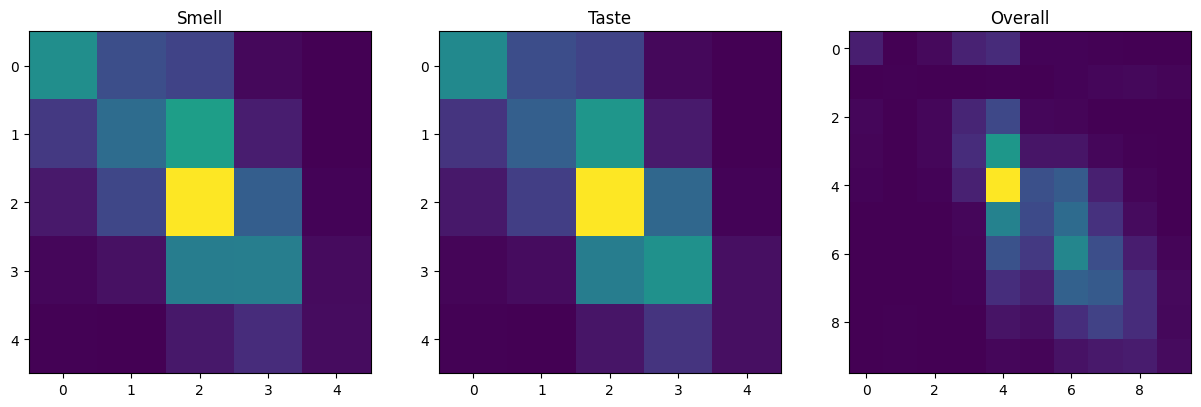

In [57]:
## Matrizes de confusão

cm_smell = print_confusion_matrix(classes_smell_teste, y_pred_sm)
cm_taste = print_confusion_matrix(classes_taste_teste, y_pred_ts)
cm_overall = print_confusion_matrix(classes_overall_teste, y_pred_ov)

print('Matriz de confusão para o modelo smell: \n', cm_smell, '\n')
print('Matriz de confusão para o modelo taste: \n', cm_taste, '\n')
print('Matriz de confusão para o modelo overall: \n', cm_overall, '\n')

## Demonstração gráfica, subplot, das matrizes de confusão

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(cm_smell)
axs[0].set_title('Smell')
axs[1].imshow(cm_taste)
axs[1].set_title('Taste')
axs[2].imshow(cm_overall)
axs[2].set_title('Overall')
plt.show()



Através das cores das matrizes de confusão, verifica-se que os dados apresentam-se com uma taxa de acerto (TP+TF) que poderia ser melhor. Sendo que o amarelo representa o maior número presente na matriz, e aproximando do roxo temos o (perto de) zero, os dados deveriam apresentar uma diagonal quase perfeita com os azuis e amarelo.
- Tal não acontece já que, verificado pelo score, existe uma taxa de erro elevada 

### KNN <a name="knnmult"></a>

In [71]:
def find_best_values_knn(data, target, neigh_list):
    """ @data -> matriz com o tf-idf de cada documento
        @target -> lista com a classificação binária de cada review
        @neigh_list -> lista com o número de vizinhos a testar

        Retorna os melhores valores para o modelo knn
    """
    best_score = 0
    for neigh in neigh_list:
        print('Iteração no número de vizinhos atual: ', neigh)
        model = KNeighborsClassifier(n_neighbors=neigh)
        model.fit(data, target)
        score = model.score(data, target)
        if score > best_score:
            best_neigh = neigh
            best_score = score
    return best_neigh, best_score 

Antes de proceder à classificação, irá ser procurado o melhor valor de vizinhança.

In [74]:
k = [5, 9, 11]

## Testar os melhores vizinhos para cada classe

best_neigh_sm, best_score_sm = find_best_values_knn(reviews_texto_treino_tfidf_sm[:40000], classes_smell_treino[:40000], k)
print('Melhor número de vizinhos para smell: ', best_neigh_sm)
print('Melhor score para smell: ', best_score_sm)

best_neigh_ts, best_score_ts = find_best_values_knn(reviews_texto_treino_tfidf_ts[:40000], classes_taste_treino[:40000], k)
print('Melhor número de vizinhos para taste: ', best_neigh_ts)
print('Melhor score para taste: ', best_score_ts)

best_neigh_ov, best_score_ov = find_best_values_knn(reviews_texto_treino_tfidf_ov[:40000], classes_overall_treino[:40000], k)
print('Melhor número de vizinhos para overall: ', best_neigh_ov)
print('Melhor score para overall: ', best_score_ov)

Iteração no número de vizinhos atual:  5
Iteração no número de vizinhos atual:  9
Iteração no número de vizinhos atual:  11
Melhor número de vizinhos para smell:  5
Melhor score para smell:  0.571425
Iteração no número de vizinhos atual:  5
Iteração no número de vizinhos atual:  9
Iteração no número de vizinhos atual:  11
Melhor número de vizinhos para taste:  5
Melhor score para taste:  0.574325
Iteração no número de vizinhos atual:  5
Iteração no número de vizinhos atual:  9
Iteração no número de vizinhos atual:  11
Melhor número de vizinhos para overall:  5
Melhor score para overall:  0.468


Verificados os melhores valores, irá se aplicar ao modelo final.

In [77]:
## Aplicar o modelo knn aos dados com os melhores valores de vizinhos para teste, smell e overall

## Smell
print('A aplicar os modelos knn... --> Por ordem: smell, taste e overall \n')
print('Modelo Smell em treino...')
model_knn_sm = apply_knn_classifier(best_neigh_sm)
model_knn_sm.fit(reviews_texto_treino_tfidf_sm, classes_smell_treino)
print('Treinado!', '\n', 'Modelo Smell em teste...')

# Prever os dados de teste
print('A prever os dados...')
y_pred_sm = model_knn_sm.predict(reviews_texto_teste_tfidf_sm)
print('Dados previstos! \n')

# Verificar as pontuações
print('A verificar as pontuações...')
score_train_sm = model_knn_sm.score(reviews_texto_treino_tfidf_sm, classes_smell_treino)
score_test_sm = model_knn_sm.score(reviews_texto_teste_tfidf_sm, classes_smell_teste)
print('Pontuações verificadas! \n', '-'*100)

## Taste
print('Modelo Taste em treino...')
model_knn_ts = apply_knn_classifier(best_neigh_ts)
model_knn_ts.fit(reviews_texto_treino_tfidf_ts, classes_taste_treino)
print('Treinado!', '\n', 'Modelo Taste em teste...')

# Prever os dados de teste
print('A prever os dados...')
y_pred_ts = model_knn_ts.predict(reviews_texto_teste_tfidf_ts)
print('Dados previstos! \n')

# Verificar as pontuações
print('A verificar as pontuações...')
score_train_ts = model_knn_ts.score(reviews_texto_treino_tfidf_ts, classes_taste_treino)
score_test_ts = model_knn_ts.score(reviews_texto_teste_tfidf_ts, classes_taste_teste)
print('Pontuações verificadas! \n', '-'*100)

## Overall
print('Modelo Overall em treino...')
model_knn_ov = apply_knn_classifier(best_neigh_ov)
model_knn_ov.fit(reviews_texto_treino_tfidf_ov, classes_overall_treino)
print('Treinado!', '\n', 'Modelo Overall em teste...')

# Prever os dados de teste
print('A prever os dados...')
y_pred_ov = model_knn_ov.predict(reviews_texto_teste_tfidf_ov)
print('Dados previstos! \n')

# Verificar as pontuações
print('A verificar as pontuações...')
score_train_ov = model_knn_ov.score(reviews_texto_treino_tfidf_ov, classes_overall_treino)
score_test_ov = model_knn_ov.score(reviews_texto_teste_tfidf_ov, classes_overall_teste)
print('Pontuações verificadas! \n', '-'*100)


A aplicar os modelos knn... --> Por ordem: smell, taste e overall 

Modelo Smell em treino...
Treinado! 
 Modelo Smell em teste...
A prever os dados...
Dados previstos! 

A verificar as pontuações...
Pontuações verificadas! 
 ----------------------------------------------------------------------------------------------------
Modelo Taste em treino...
Treinado! 
 Modelo Taste em teste...
A prever os dados...
Dados previstos! 

A verificar as pontuações...
Pontuações verificadas! 
 ----------------------------------------------------------------------------------------------------
Modelo Overall em treino...
Treinado! 
 Modelo Overall em teste...
A prever os dados...
Dados previstos! 

A verificar as pontuações...
Pontuações verificadas! 
 ----------------------------------------------------------------------------------------------------


In [79]:
## Demonstrações gerais com os valores em tabela

print('Previsão de teste smell: ', y_pred_sm)
print('Previsão de teste taste: ', y_pred_ts)
print('Previsão de teste overall: ', y_pred_ov, '\n')
print('Score treino smell: ', score_train_sm)
print('Score teste smell: ', score_test_sm, '\n')
print('Score treino taste: ', score_train_ts)
print('Score teste taste: ', score_test_ts, '\n')
print('Score treino overall: ', score_train_ov)
print('Score teste overall: ', score_test_ov, '\n')

Previsão de teste smell:  ['3/5' '3/5' '3/5' ... '3/5' '3/5' '2/5']
Previsão de teste taste:  ['3/5' '2/5' '3/5' ... '3/5' '3/5' '2/5']
Previsão de teste overall:  ['6/10' '7/10' '5/10' ... '6/10' '5/10' '6/10'] 

Score treino smell:  0.57604
Score teste smell:  0.3708 

Score treino taste:  0.5773733333333333
Score teste taste:  0.36404 

Score treino overall:  0.47173333333333334
Score teste overall:  0.22424 



Matriz de confusão para o modelo smell: 
 [[1598 1529 1413  321   37]
 [ 794 1965 2589  549   41]
 [ 558 1796 4325 1361   83]
 [ 195  744 2445 1308  137]
 [  43  136  548  411   74]] 

Matriz de confusão para o modelo taste: 
 [[1468 1477 1493  353   29]
 [ 681 1579 2442  669   25]
 [ 575 1665 4222 1642   76]
 [ 225  686 2480 1752  128]
 [  59  143  558  493   80]] 

Matriz de confusão para o modelo overall: 
 [[ 163    8   94  240  346  137   87   49   26    4]
 [   2   21    6    9   39   45   43   35   33   12]
 [  90   17   97  245  474  148  127   56   20    1]
 [  94   32  116  447 1130  389  298  130   57    6]
 [ 112   49  170  618 2190 1122  898  375  146   22]
 [  40   41   80  298 1235  845  868  406  137   27]
 [  29   75   68  221  984  774 1022  566  218   53]
 [  23   72   33  112  667  594  785  571  298   44]
 [  15   66   21   72  287  323  459  364  224   42]
 [  13   46    9   39  132  137  164  169  131   26]] 



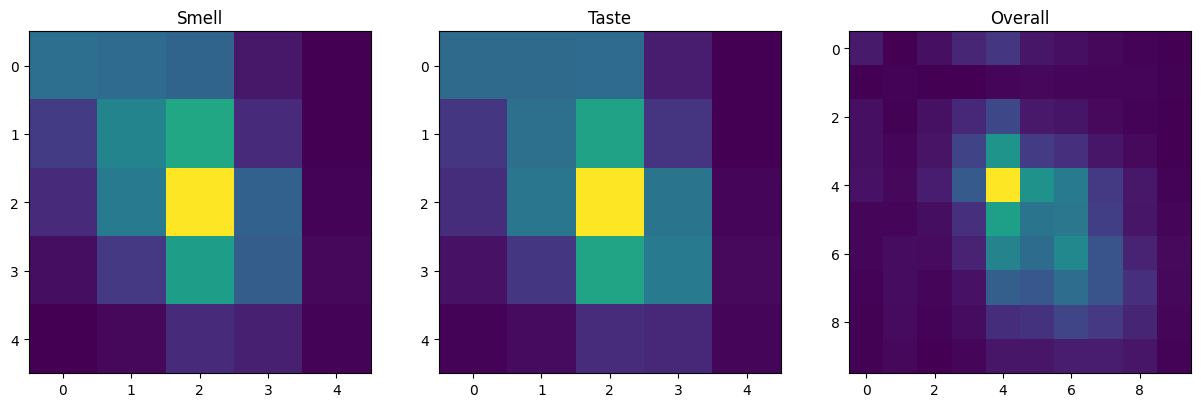

In [84]:
## Matrizes de confusão

cm_smell = print_confusion_matrix(classes_smell_teste, y_pred_sm)
cm_taste = print_confusion_matrix(classes_taste_teste, y_pred_ts)
cm_overall = print_confusion_matrix(classes_overall_teste, y_pred_ov)

print('Matriz de confusão para o modelo smell: \n', cm_smell, '\n')
print('Matriz de confusão para o modelo taste: \n', cm_taste, '\n')
print('Matriz de confusão para o modelo overall: \n', cm_overall, '\n')

## Demonstração gráfica, subplot, das matrizes de confusão

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(cm_smell)
axs[0].set_title('Smell')
axs[1].imshow(cm_taste)
axs[1].set_title('Taste')
axs[2].imshow(cm_overall)
axs[2].set_title('Overall')
plt.show()

In [91]:
## Taxa de erro de cada classe

print('Taxa de erro para smell: ', taxa_erro(classes_smell_teste, y_pred_sm),'%')
print('Taxa de erro para taste: ', taxa_erro(classes_taste_teste, y_pred_ts), '%')
print('Taxa de erro para overall: ', taxa_erro(classes_overall_teste, y_pred_ov), '%')

Taxa de erro para smell:  62.92 %
Taxa de erro para taste:  63.596 %
Taxa de erro para overall:  77.576 %


Conclui-se que o KNN em multi-classe tem uma taxa de erro elevadíssima. Isto pode-se justificar devido ao facto de estar a tentar agrupar palavras que pertençam a classes diferentes, sendo a mesma palavra presente em várias pontuações de 0 a 5 na crítica. 
- Assim, ao tentar agrupar a palavra aos k-vizinhos mais próximos, o algoritmo apresenta erro devido a um certo fator de indecisão no 'grupo' de vizinhos em que deveria colocar a palavra

<hr>

## Classificadores Adicionais <a name="adic"></a>

### PCA (<i>Principal Component Analysis) <a name="pca"></a>

A análise em componentes principais é um algoritmo de aprendizagem `não supervisionada`, ou seja, as suas classificações não terão em contas as classes dos dados em questão. 

Ao trabalhar com dados de dimensões elevadas (como é o caso neste projeto), os algoritmos de aprendizagem automática costumam ter tendência a entrar em sobre-aprendizagem. O algoritmo de PCA executa uma redução de dimensões antes de aplicar o algoritmo de aprendizagem supervisionada em questão.

Resumindo as suas funcionalidades, o algoritmo de PCA reduz o número de variáveis (independentes) num conjunto de dados, mantendo ao máximo a informação original, transformando as variáveis originais num novo conjunto de variáveis, as <b>componentes principais</b>

Para que se possa aplicar o algoritmo de PCA, usar-se-à uma variação sua que faz uso de matrizes esparsas, o `TruncatedSVD()`.
- O objetivo é aplicar o algoritmo de regressão logística com o novo conjunto de dados criado pelo PCA, ou seja, o conjunto de componentes principais, referido acima
    - É de notar que para aplicar ao conjunto de dados completo, procurar-se-à qual o melhor número de componentes numa fase inicial, num <i>slice</i> do conjunto de treino e teste e, posteriormente, aplicar-se-ão os algoritmos a todos os conjuntos completos (binários e multiclasse)

In [18]:
def truncated_svd(n_components, x_train, x_test, y_train, y_test):
    """ @n_components -> número de componentes a reduzir
        @data_fit -> matriz com o tf-idf de cada documento

        Retorna a matriz com o tf-idf reduzida
    """
    svd = TruncatedSVD(n_components=n_components).fit(x_train)
    svd_train_transform = svd.transform(x_train)
    svd_test_transform = svd.transform(x_test)
    return svd_train_transform, svd_test_transform

def check_best_n_components(nr_comp_list):
    """ @nr_comp_list -> lista com o número de componentes a reduzir

        Retorna o melhor número de componentes a utilizar no modelo em questão
    """
    best_penalty = 'l2'
    best_C = 1
    critica_tfidf_test = critica_tfidf_teste[:15000]
    classe_ts_bin_posi = classe_ts_bin_pos[:15000]
    critica_tfidf_train = critica_tfidf_treino[:25000]
    classe_tr_bin_posi = classe_tr_bin_pos[:25000]

    x_train_pca, x_test_pca = truncated_svd(nr_comp_list, critica_tfidf_train, critica_tfidf_test, classe_tr_bin_posi, classe_ts_bin_posi)
    ## Aplicar o modelo knn usando os dados transformados do truncated_svd, caso binário
    log_reg_pca = apply_best_log_regress(best_penalty, best_C).fit(x_train_pca, classe_tr_bin_posi)
    score_train_pca = log_reg_pca.score(x_train_pca, classe_tr_bin_posi)
    score_test_pca = log_reg_pca.score(x_test_pca, classe_ts_bin_posi)
    print('Score treino: ', score_train_pca)
    print('Score teste: ', score_test_pca, '\n')

#### Aplicação do PCA para caso binário <a name="pcabin"></a>

In [39]:
## Testar o melhor valor de components PCA

nr_components = [100, 500, 1000, 3000, 5000]

for nr_comp in nr_components:
    print('Iteração no número de componentes atual: ', nr_comp)
    check_best_n_components(nr_comp)


Iteração no número de componentes atual:  100
Score treino:  0.93288
Score teste:  0.9606 

Iteração no número de componentes atual:  500
Score treino:  0.93536
Score teste:  0.9605333333333334 

Iteração no número de componentes atual:  1000
Score treino:  0.93656
Score teste:  0.961 

Iteração no número de componentes atual:  3000
Score treino:  0.9382
Score teste:  0.9610666666666666 

Iteração no número de componentes atual:  5000
Score treino:  0.9384
Score teste:  0.9611333333333333 



Para não entrar em pesquisas exaustivas, manteve-se um teto de 5000. Ora, detetou-se que quanto maior o número de componentes, maior a percentagem de acerto em ambos os conjuntos (teste e treino)
- Assim, chegou-se à conclusão que o melhor número de componentes a usar será `n_components=5000`

In [20]:
## Aplicar o número de 5000 componentes ao modelo de regressão logística
##    fazendo uso do conjunto de teste e treino completos

best_penalty = 'l2'
best_C = 1

x_train_pca_positivo, x_test_pca_positivo = truncated_svd(5000, critica_tfidf_treino, critica_tfidf_teste, classe_tr_bin_pos, classe_ts_bin_pos)
x_train_pca_negativo, x_test_pca_negativo = truncated_svd(5000, critica_tfidf_treino, critica_tfidf_teste, classe_tr_bin_neg, classe_ts_bin_neg)

## Aplicar o modelo knn usando os dados transformados do truncated_svd, caso binário
print('A aplicar o modelo de regressão logística com os dados transformados do PCA...')
print('Modelo Positivo...')
log_reg_pca_positivo = apply_best_log_regress(best_penalty, best_C).fit(x_train_pca_positivo, classe_tr_bin_pos)
print('Treinado!', '\n', 'Modelo Negativo...')
log_reg_pca_negativo = apply_best_log_regress(best_penalty, best_C).fit(x_train_pca_negativo, classe_tr_bin_neg)
print('Treinado!')
print('Modelos treinados! \n')

# Prever os dados de teste
print('A prever os dados...')
y_pred_pos = log_reg_pca_positivo.predict(x_test_pca_positivo)
y_pred_neg = log_reg_pca_negativo.predict(x_test_pca_negativo)
print('Dados previstos! \n')

# Verificar as pontuações
print('A verificar as pontuações...')
score_train_pos = log_reg_pca_positivo.score(x_train_pca_positivo, classe_tr_bin_pos)
score_train_neg = log_reg_pca_negativo.score(x_train_pca_negativo, classe_tr_bin_neg)
score_test_pos = log_reg_pca_positivo.score(x_test_pca_positivo, classe_ts_bin_pos)
score_test_neg = log_reg_pca_negativo.score(x_test_pca_negativo, classe_ts_bin_neg)
print('Pontuações verificadas! \n')

A aplicar o modelo de regressão logística com os dados transformados do PCA...
Modelo Positivo...
Treinado! 
 Modelo Negativo...
Treinado!
Modelos treinados! 

A prever os dados...
Dados previstos! 

A verificar as pontuações...
Pontuações verificadas! 



In [21]:
## Demonstrações
print('Previsão de teste positivos: ', y_pred_pos)
print('Previsão de teste negativos: ', y_pred_neg)
print('Score treino positivo: ', score_train_pos)
print('Score treino negativo: ', score_train_neg)
print('Score teste positivo: ', score_test_pos)
print('Score teste negativo: ', score_test_neg)

Previsão de teste positivos:  [0 0 0 ... 0 0 0]
Previsão de teste negativos:  [0 0 0 ... 0 0 0]
Score treino positivo:  0.9395333333333333
Score treino negativo:  0.9632266666666667
Score teste positivo:  0.956
Score teste negativo:  0.91688


Matriz de confusão para o modelo positivo: 
 [[21452  2437]
 [  503   608]] 

Matriz de confusão para o modelo negativo: 
 [[20185  2386]
 [  847  1582]]


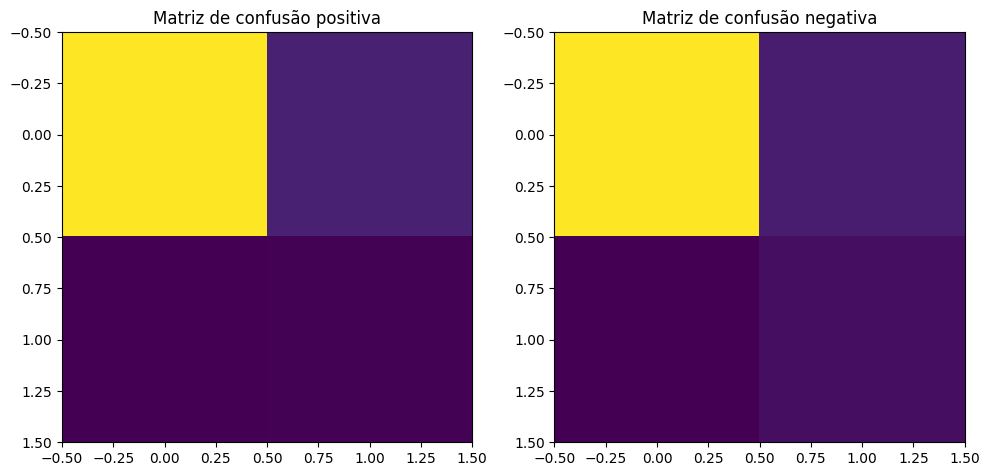

Recall positivo:  0.5472547254725473
Recall negativo:  0.6512968299711815
Taxa de erro no conjunto negativo:  12.931999999999999 %
Taxa de erro no conjunto positivo:  11.76 %


In [69]:
## Verificação da matriz de confusão

print('Matriz de confusão para o modelo positivo: \n', print_confusion_matrix(classe_ts_bin_pos, y_pred_pos), '\n')
print('Matriz de confusão para o modelo negativo: \n', print_confusion_matrix(classe_ts_bin_neg, y_pred_neg))

# Sublot das matrizes de confusão

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(print_confusion_matrix(classe_ts_bin_pos, y_pred_pos))
plt.title('Matriz de confusão positiva')
plt.subplot(1, 2, 2)
plt.imshow(print_confusion_matrix(classe_ts_bin_neg, y_pred_neg))
plt.title('Matriz de confusão negativa')
plt.tight_layout()
plt.show()



## Recall

recall_pos_pca = recall_score(classe_ts_bin_pos, y_pred_pos)
recall_neg_pca = recall_score(classe_ts_bin_neg, y_pred_neg)

print('Recall positivo: ', recall_pos_pca)
print('Recall negativo: ', recall_neg_pca)

print('Taxa de erro no conjunto negativo: ', taxa_erro(classe_ts_bin_neg, y_pred_neg), '%')
print('Taxa de erro no conjunto positivo: ', taxa_erro(classe_ts_bin_pos, y_pred_pos), '%')

Após aplicação do PCA verifica-se uma taxa de acerto ligeiramente mais elevada que no modelo logístico normal. Isto deve-se, como abordado na introdução teórica ao PCA, à redução aos componentes principais, reduzindo a taxa de erro já que há menos dimensões mas manteve-se a informação necessária a uma boa classificação.

#### Aplicação do PCA para caso multiclasse <a name="pcamult"></a>

In [16]:
## Verificar para o 'smell' quais os melhores números de componentes a utilizar

def check_best_n_components_smell(nr_comp_list):
    """ @nr_comp_list -> lista com o número de componentes a reduzir

        Retorna o melhor número de componentes a utilizar no modelo em questão,
        treinando com o modelo de regressão logística
    """
    best_penalty = 'l2'
    best_C = 1
    critica_tr_smell_reduced = reviews_texto_treino_tfidf_sm_reduced[:25000]
    classe_tr_smell = ytr_split_sm[:25000]
    critica_ts_smell_reduced = reviews_texto_teste_tfidf_sm_reduced[:15000]
    classe_ts_smell = yts_split_sm[:15000]

    x_train_pca, x_test_pca = truncated_svd(nr_comp_list, critica_tr_smell_reduced, critica_ts_smell_reduced, classe_tr_smell, classe_ts_smell)
    
    ## Aplicar o modelo regressão logística para smell usando os dados transformados do truncated_svd
    log_reg_pca = apply_best_log_regress(best_penalty, best_C).fit(x_train_pca, classe_tr_smell)
    score_train_pca = log_reg_pca.score(x_train_pca, classe_tr_smell)
    score_test_pca = log_reg_pca.score(x_test_pca, classe_ts_smell)
    print('Score treino: ', score_train_pca)
    print('Score teste: ', score_test_pca, '\n')

<img src="./output.png">

In [36]:
## Aplicação do PCA para cada classe (smell, taste, overall)

x_train_pca_sm, x_test_pca_sm = truncated_svd(500, reviews_texto_treino_tfidf_sm_reduced, reviews_texto_teste_tfidf_sm_reduced, ytr_split_sm, yts_split_sm)
x_train_pca_ts, x_test_pca_ts = truncated_svd(500, reviews_texto_treino_tfidf_ts_reduced, reviews_texto_teste_tfidf_ts_reduced, ytr_split_ts, yts_split_ts)
x_train_pca_ov, x_test_pca_ov = truncated_svd(500, reviews_texto_treino_tfidf_ov_reduced, reviews_texto_teste_tfidf_ov_reduced, ytr_split_ov, yts_split_ov)

In [38]:
## Smell

best_C = 1
best_penalty = 'l2'

print('A aplicar o modelo de regressão logística com os dados transformados do PCA...')
print('Modelo Smell...')
log_reg_pca_sm = apply_best_log_regress(best_penalty, best_C).fit(x_train_pca_sm, ytr_split_sm)
print('Treinado!', '\n', 'Modelo Smell...')
log_reg_pca_ts = apply_best_log_regress(best_penalty, best_C).fit(x_train_pca_ts, ytr_split_ts)
print('Treinado!', '\n', 'Modelo Smell...')
log_reg_pca_ov = apply_best_log_regress(best_penalty, best_C).fit(x_train_pca_ov, ytr_split_ov)
print('Treinado!')
print('Modelos treinados! \n')

# Prever os dados de teste
print('A prever os dados...')
y_pred_sm = log_reg_pca_sm.predict(x_test_pca_sm)
y_pred_ts = log_reg_pca_ts.predict(x_test_pca_ts)
y_pred_ov = log_reg_pca_ov.predict(x_test_pca_ov)
print('Dados previstos! \n')

# Verificar as pontuações
print('A verificar as pontuações...')
score_train_sm = log_reg_pca_sm.score(x_train_pca_sm, ytr_split_sm)
score_train_ts = log_reg_pca_ts.score(x_train_pca_ts, ytr_split_ts)
score_train_ov = log_reg_pca_ov.score(x_train_pca_ov, ytr_split_ov)
score_test_sm = log_reg_pca_sm.score(x_test_pca_sm, yts_split_sm)
score_test_ts = log_reg_pca_ts.score(x_test_pca_ts, yts_split_ts)
score_test_ov = log_reg_pca_ov.score(x_test_pca_ov, yts_split_ov)
print('Pontuações verificadas! \n')

## Demonstrações
print('Previsão de teste smell: ', y_pred_sm)
print('Previsão de teste taste: ', y_pred_ts)
print('Previsão de teste overall: ', y_pred_ov, '\n')
print('Score treino smell: ', score_train_sm)
print('Score treino taste: ', score_train_ts)
print('Score treino overall: ', score_train_ov)
print('Score teste smell: ', score_test_sm)
print('Score teste taste: ', score_test_ts)
print('Score teste overall: ', score_test_ov)

A aplicar o modelo de regressão logística com os dados transformados do PCA...
Modelo Smell...
Treinado! 
 Modelo Smell...
Treinado! 
 Modelo Smell...
Treinado!
Modelos treinados! 

A prever os dados...
Dados previstos! 

A verificar as pontuações...
Pontuações verificadas! 

Previsão de teste smell:  ['4/5' '4/5' '3/5' ... '2/5' '4/5' '3/5']
Previsão de teste taste:  ['3/5' '3/5' '3/5' ... '3/5' '3/5' '3/5']
Previsão de teste overall:  ['6/10' '4/10' '6/10' ... '7/10' '6/10' '6/10'] 

Score treino smell:  0.5059428571428571
Score treino taste:  0.5196
Score treino overall:  0.3777142857142857
Score teste smell:  0.46453333333333335
Score teste taste:  0.474
Score teste overall:  0.3036


Matriz de confusão para o modelo smell: 
 [[ 875  343  241   23    1]
 [ 386  557  706   97    1]
 [ 207  385 1546  338    0]
 [  67   87  767  496    5]
 [  24   17  129  192   10]] 

Matriz de confusão para o modelo taste: 
 [[ 918  230  289   23    1]
 [ 380  408  699   84    0]
 [ 190  322 1574  373    8]
 [  61   58  824  636   12]
 [  28    9  112  242   19]] 

Matriz de confusão para o modelo overall: 
 [[ 121    0   16   69  121    6    3    6    0    0]
 [   1    0    0    2    8    2   15   22   12   10]
 [  46    0   12   87  205    8    4    5    1    1]
 [  38    0    8  122  559   43   41   17    4    2]
 [  25    0    8   81 1183  174  184   58   12    0]
 [   5    0    1   24  633  160  253  115   12    1]
 [  10    0    1   12  386  172  350  226   37    4]
 [   9    0    0    9  215  103  291  258   50   11]
 [   6    0    0    7   74   36  173  187   61    8]
 [   3    0    1    3   33   11   58   81   58   10]] 



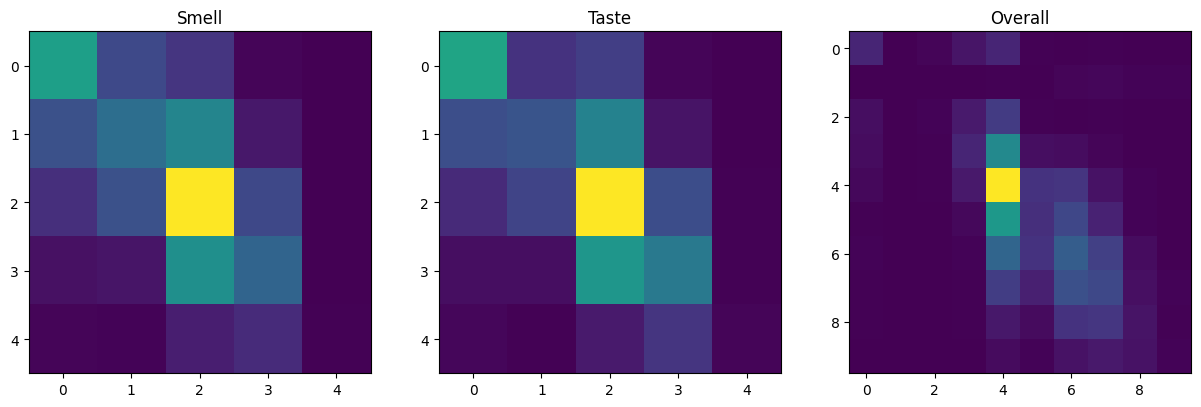

In [42]:
## Matrizes de confusão

cm_smell = print_confusion_matrix(yts_split_sm, y_pred_sm)
cm_taste = print_confusion_matrix(yts_split_ts, y_pred_ts)
cm_overall = print_confusion_matrix(yts_split_ov, y_pred_ov)

print('Matriz de confusão para o modelo smell: \n', cm_smell, '\n')
print('Matriz de confusão para o modelo taste: \n', cm_taste, '\n')
print('Matriz de confusão para o modelo overall: \n', cm_overall, '\n')

## Demonstração gráfica, subplot, das matrizes de confusão

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(cm_smell)
axs[0].set_title('Smell')
axs[1].imshow(cm_taste)
axs[1].set_title('Taste')
axs[2].imshow(cm_overall)
axs[2].set_title('Overall')
plt.show()

### K-Means (Clustering) <a name="kmeans"></a>

O algoritmo de clustering K-Means (K-Médias, em português) é um método de aprendizagem não supervisionada que agrupa dados semelhantes em <b>nuvens de dados</b>. Este algoritmo funciona da seguinte forma:
- Seleciona k centroides (definidos como hiper-parâmetro pelo programador)
- Os dados são atribuídos aos centroides mais próximos
- Após todos os dados estarem atribuídos, as posições dos centróides são modificadas até existir uma convergência de posição, ou seja, recursivamente, irá haver alteração nas suas posições até que todos os centroides fiquem fixos

Trabalhando com o modelo do projeto, Bag of Words, este algoritmo é útil para agrupar as palavras em significados semelhantes, sendo que cada nuvem considera palavras ocorridas em frequência semelhante, num grupo de significados.

In [25]:
def apply_kmeans(n_clusters, data):
    """ @n_clusters -> número de clusters a utilizar
        @data -> matriz com o tf-idf de cada documento

        Retorna o modelo kmeans treinado
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(data)
    return kmeans

Para se encontrar o melhor número de clusters, procurar-se-à através do `método de cotovelo (elbow method)` do K-Means.

Este método funciona realizando um 'plot' da soma dos quadrados das distâncias dentro das nuvens de dados (WCSS - Within-Cluster Sum of Squares), em cada numero total de centroides. 
- A ideia deste método resume-se em encontrar no gráfico desenhado (através do 'plot') o "cotovelo" da linha desenhada, ou seja, onde o WCSS começa a desnivelar, criando uma forma de "cotovelo" no gráfico. Esse ponto de desnivel representa o número ótimo de clusters no conjunto de dados.

In [33]:
## Testar o Kmeans para caso binário com 2 clusters

n_clusters_values = list(range(100, 701, 100))
inertia_values = []

for n_clusters in n_clusters_values:
    print('Iteração no número de clusters atual: ', n_clusters)
    kmeans_model = apply_kmeans(n_clusters, critica_tfidf_treino[:10000])
    inertia_values.append(kmeans_model.inertia_)

Iteração no número de clusters atual:  100


C:\Users\h_e_m\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteração no número de clusters atual:  200


C:\Users\h_e_m\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteração no número de clusters atual:  300


C:\Users\h_e_m\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteração no número de clusters atual:  400


C:\Users\h_e_m\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteração no número de clusters atual:  500


C:\Users\h_e_m\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteração no número de clusters atual:  600


C:\Users\h_e_m\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteração no número de clusters atual:  700


C:\Users\h_e_m\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Proceder-se-à ao desenho do cotovelo.

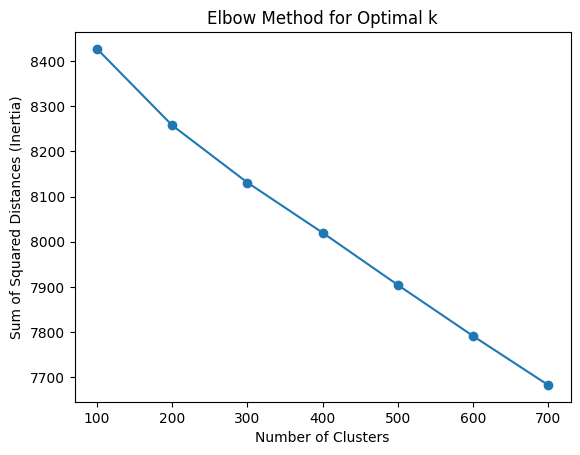

In [35]:
plt.plot(n_clusters_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.show()

Assim, analisando o gráfico conclui-se que o melhor número de clusters será o <b>200</b>, visto que é onde ocorre o cotovelo. Passar-se-à,então, à classificação dos dados completos. 

In [26]:
## Aplicar o Kmeans com o melhor cluster

n_clusters = 200
kmeans_model = apply_kmeans(n_clusters, critica_tfidf_treino)

C:\Users\h_e_m\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [32]:
y_pred = kmeans_model.predict(critica_tfidf_teste)

print('Silhouette Score: ', silhouette_score(critica_tfidf_teste, y_pred))

Silhouette Score:  0.002559446260770279


<hr>

#### Escrita de Todos os Modelos para Pickle

In [ ]:
# Modelos Binários

pickle.dump(model_knn_pos, open('./model_knn_pos.p', 'wb'))
pickle.dump(model_knn_neg, open('./model_knn_neg.p', 'wb'))

pickle.dump(model_log_regress_pos, open('./model_log_regress_pos.p', 'wb'))
pickle.dump(model_log_regress_neg, open('./model_log_regress_neg.p', 'wb'))

pickle.dump(model_svc_pos, open('./model_svc_pos.p', 'wb'))
pickle.dump(model_svc_neg, open('./model_svc_neg.p', 'wb'))

# Modelos Multiclasse

pickle.dump(model_knn_sm, open('./model_knn_sm.p', 'wb'))
pickle.dump(model_knn_ts, open('./model_knn_ts.p', 'wb'))
pickle.dump(model_knn_ov, open('./model_knn_ov.p', 'wb'))

pickle.dump(model_log_regress_sm, open('./model_log_regress_sm.p', 'wb'))
pickle.dump(model_log_regress_ts, open('./model_log_regress_ts.p', 'wb'))
pickle.dump(model_log_regress_ov, open('./model_log_regress_ov.p', 'wb'))

<hr>

# <center> 4. Conclusões <a name="conc"></a> 

Consideramos que o projeto em si não beneficia de testes altamente intensivos, visto que o tempo de execução dos classificadores é demasiado longo para tal. De modo a simplificar as buscas dos melhores hiper-parâmetros, o melhor a usar é uma versão reduzida do vocabulário e estudar a razão teórica de usar diferentes kernels, números de vizinhos, penalizações, entre outros (hiper-parâmetros) para poder aplicar esse estudo na escolha dos quais deveremos testar.
- No entanto, claro que a busca pelos melhores hiper-parâmetros é necessária, deverá haver um equilíbrio na escolha de quais testar

A classificação multiclasse vai apresentar uma maior taxa de erros em relação às classificações binárias visto que uma palavra na última apenas pertence a duas classes (0 e 1), enquanto que no multiclasse a palavra (por exemplo, 'bom') pode aparecer em várias críticas sejam elas positivas ou negativas (ou até mesmo intermédias). A aplicação dos componentes principais (PCA) melhorou bastante o resultado já que reduz as dimensões, não removendo significado ao texto em si. Logo, aplicando um método supervisionado após este método não supervisionado, a taxa de acerto aumenta razoavelmente.

É de notar que não processando as 'stop words' acabamos por ter um vocabulário mais rico, visto que as críticas estão em inglês e a gramática inglesa decide que há palavras cruciais à nossa classificação que são consideradas 'stop words'.

O tempo de execução dos classificadores é bastante longo. Foi necessário verificar que os testes apresentavam uma boa afinação dos hiper-parâmetros antes de aplicar nas críticas gerais. Este problema do tempo de execução apresentou-se como sendo um obstáculo bastante problemático. 
- Outro enorme problema com que nos deparamos é o consumo de RAM, visto que após demasiado tempo a correr, o Python armazenava demasiadas variáveis, tendo que reiniciar o kernel, perdendo imenso tempo a correr as células de pré-processamento novamente
    - Uma solução passou por começar a correr apenas as células estritamente necessárias, tentando ao máximo economizar a RAM consumida pelo kernel

O uso da máquina de suporte vetorial 'SVC' consumiu demasiado tempo para ser viável a sua execução. Assim, consideramos usar o 'LinearSVC' que apresentou uma execução consideravelmente mais rápida (em vez de 8h+ a correr, demorou 1min33s o que é uma diferença brutal em termos computacionais).

As matrizes de confusão foram o teste mais útil para verificar o erro aplicado nos classificadores visto que a diagonal principal apresenta as taxas de acerto e no caso da multi-classe, principalmente, era possível verificar a quantidade de documentos que estavam a ser classificados como errados (e sabendo que a taxa de erro neste tipo de classificadores é bastante mais elevada que a binária, este método de verificaçao permite detetar onde ocorriam os maiores erros)

Conclui-se que o projeto permite aprofundar os conhecimentos abordados ao longo da unidade curricular de Aprendizagem Automática, aplicando a matéria lecionada e avaliada ao longo das fichas e laboratórios sem qualquer exceção, fornecendo uma boa base para o tópico de '<i>machine learning</i>'

<hr>

# <center> Bibliografia <a name="bibliografia"></a>

Slides da Unidade Curricular de Aprendizagem Automática - <i>Eng. Gonçalo Marques</i>

https://www.geeksforgeeks.org/understanding-logistic-regression/

https://www.geeksforgeeks.org/supervised-unsupervised-learning/

https://www.geeksforgeeks.org/clustering-in-machine-learning/

https://www.geeksforgeeks.org/ml-linear-regression/

https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1

https://www.geeksforgeeks.org/multiclass-classification-using-scikit-learn/

https://medium.com/all-things-ai/in-depth-parameter-tuning-for-svc-758215394769

https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html


<hr>

# <center> FIM